<a href="https://www.kaggle.com/code/tetleysteabags/climbing-performance-metrics-analysis?scriptVersionId=146979471" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**The Impact of Strength Metrics on Climbing Performance**

Within recent years companies such as Lattice have begun using data analytics to inform climbers of where their potential weaknesses are to better personalise training plans (and hopefully improve long term performance).

Many of these datasets are not publicly available, but the team at Power Company Climbing have been kind enough to share theirs.

In this notebook I am using a dataset from Power Company Climbing which contains around 600 self reported members, providing a variety of climbing benchmarks. The goal of the workbook is to test different machine learning models to determine which metrics play the largest role in climbing performance, and whether we can use this data to then predict climbing grades.

The workbook splits out bouldering and sport climbing and performs the analysis on these two variations of climbing separately.

![Burden of dreams](https://cdn.climbing.com/wp-content/uploads/2023/04/DSC01953-scaled.jpg?crop=535:301&width=1070&enable=upscale)

The dataset contains the following variables:

'age',

'sex',

'max_boulder', - Max grade of boulder on the V scale climbed in the last year

'max_sport', - Max sport climbing grade climbed in the last year 

'exp', - years bouldering

'trainexp', - years specifically training for bouldering

'country',

'state',

'rock', - Rock type climbed on

'season', - Months per year spent climbing outside

'days', - Days per month spent climbing outside

'height',

'weight',

'span', - Wing span

'pullup',

'pushup',

'continuous', - Continuous hang from a 20mm edge

'maxhang', - Max weight added to hang for 10 seconds from a 20mm edge

'weightedpull', - Max weight added for single pull up

'repeaters1', - 7:3 hang:recovery on a 20mm edge

'longcamp', - long campus, unclear what rungs

'shortcamp', - short campus, unclear what rungs

**Final Results**

The models have produced different results for climbing vs bouldering, indicating that it's more important to be stronger in specific areas if you want to sport climb or boulder.

For bouldering, the most important metrics were:

1. strength_to_weight_maxhang: so essentially strengthening your max hangs on a 20mm edge
2. strength_to_weight_pull: the number of pullups you can do
3. strength_to_weight_weightpull: the number of pullups you can do, with your max weight added on
4. continuous / repeaters: these were a joint 4th. Continious is how long you can hang from a 20mm edge, and repeaters are 7s hands, 3s recovery on a 20mm edge


For sport climbing, the results are quite different: 

1. shortcamp: It's not clear what this metric is, but we can assume it's climbing up the campus board using all the rungs
2. repeaters: Repeaters are 7s hands, 3s recovery on a 20mm edge
3. strength_to_weight_weightpull: The number of pullups you can do, with your max weight added on
4. weightedpull: Weighted pullups

So, in summary:

If you want to boulder hard, make good use of the fingerboard and max hang training, including lots of weighted and non-weighted pullups (think explosive pulls with a band etc)

If you want to sport climb hard, improve your endurance on the 20mm edge, and do lots of weighted pullups.

![bibliographie](https://www.patagonia.com/blog/wp-content/uploads/2020/11/etzel_k_1399_cc_web-1280x720-1.jpg)

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import ticker
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
import shap
import mlflow
import pickle

warnings.filterwarnings('ignore')

In [43]:
# Read the data file using pandas, specifying the encoding
original_data = pd.read_csv(r'/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project/PowerCompanyAssessmentData.csv',encoding="cp1252")

# Display the first few rows of the dataframe to check everything is in order
print(original_data.columns)

# Drop the "country", "state", and "rock" columns from the dataframe, as they will not be used in the analysis
data = original_data.drop(columns=["country", "state", "rock"])
print(data.head())  # Print the dataframe again to confirm the columns have been dropped

Index(['age', 'sex', 'max_boulder', 'max_sport', 'exp', 'trainexp', 'country',
       'state', 'rock', 'season', 'days', 'height', 'weight', 'span', 'pullup',
       'pushup', 'continuous', 'maxhang', 'weightedpull', 'repeaters1',
       'longcamp', 'shortcamp', 'ohpr', 'ohll', 'dl', 'bmi_score'],
      dtype='object')
   age     sex max_boulder max_sport        exp   trainexp      season  \
0   43  Female         <V3   5.10c/d  >10 years    <1 year  7-9 months   
1   16  Female          V6   5.12c/d  7-8 years  7-8 years  4-6 months   
2   19    Male          V9   5.13c/d  >10 years  7-8 years  4-6 months   
3   34    Male          V8   5.12a/b  >10 years  5-6 years  4-6 months   
4   30  Female          V8   5.12a/b  7-8 years  3-4 years  4-6 months   

                 days  height  weight  ...  continuous  maxhang  weightedpull  \
0  3-4 days per month    65.0   151.0  ...          16     37.0          10.0   
1  5-6 days per month    64.0   125.0  ...          28     10.0         

Here I have imported the data and decided to drop the country, state, and rock type columns as I am making an assumption these variables won't have a big impact on climbing performance.

In [44]:
# Transform physical attributes from the imperial to the metric system
data['height'] = data['height'] * 2.54  # convert inches to centimeters
data['weight'] = data['weight'] * 0.45359237  # convert pounds to kilograms
data['ohpr'] = data['ohpr'] * 0.45359237  # convert pounds to kilograms
data['ohll'] = data['ohll'] * 0.45359237  # convert pounds to kilograms
data['dl'] = data['dl'] * 0.45359237  # convert pounds to kilograms
data['span'] = data['span'] * 2.54  # convert inches to centimeters
data['weightedpull'] = data['weightedpull'] * 0.45359237  # convert pounds to kilograms
data['maxhang'] = data['maxhang'] * 0.45359237  # convert pounds to kilograms

# Create new variables representing strength-to-weight ratios for different physical activities
data['strength_to_weight_pullup'] = (data['pullup'] + data['bmi_score'])/ data['bmi_score']
data['strength_to_weight_weightpull'] = (data['weightedpull'] + data['bmi_score']) / data['bmi_score']
data['strength_to_weight_maxhang'] = (data['maxhang'] + data['bmi_score']) / data['bmi_score']

# Coerce any errors during conversion of 'continuous' column to a numeric type to NaN
data['continuous'] = pd.to_numeric(data['continuous'], errors='coerce')

# Create dictionaries to map experience, season, and days climbing to numeric values
experience_dict = { "< 1 year":0,"<1 year":0,"1-2 years":1,"3-4 years":2,"5-6 years":3,"7-8 years":4,
                   "9-10 years":5, ">10 years":6, "> 10 years":6}
season_dict = {"1-3 months":1,"4-6 months":2,"7-9 months":3,"Year round":4}
days_dict = {'3-4 days per month':3.5, '5-6 days per month':5.5, '1-5 days per month':3,
       '7-8 days per month':7.5, '>10 days per month':12.5, '>15 days per month':20,
             '9-10 days per month':9.5, 'I currently do no climb outdoors':0, '15-20':17.5,}
sex_dict = {'Male':1, 'Female':2, 'Other/Prefer to Not Answer':3,'Other':3,'0':0}

# Apply the dictionaries to the respective columns
data["exp"] = data["exp"].map(experience_dict)
data["sex"] = data["sex"].map(sex_dict)
data["trainexp"] = data["trainexp"].map(experience_dict)
data["season"] = data["season"].map(season_dict)
data['days'] = data['days'].replace(days_dict)
data['days'] = pd.to_numeric(data['days'])
# Convert 'days' from per year to per month for entries from index 37 onwards as historically users inputed their climbing days like this
data["days"][37:] = data["days"][37:]/12


print(data.head())  # Display the first few rows of the dataset

   age  sex max_boulder max_sport  exp  trainexp  season  days  height  \
0   43    2         <V3   5.10c/d  6.0       0.0     3.0   3.5  165.10   
1   16    2          V6   5.12c/d  4.0       4.0     2.0   5.5  162.56   
2   19    1          V9   5.13c/d  6.0       4.0     2.0   3.0  177.80   
3   34    1          V8   5.12a/b  6.0       3.0     2.0   7.5  172.72   
4   30    2          V8   5.12a/b  4.0       2.0     2.0   5.5  172.72   

      weight  ...  repeaters1  longcamp  shortcamp       ohpr       ohll  \
0  68.492448  ...        31.0      41.0       62.0        NaN        NaN   
1  56.699046  ...       120.0       NaN        NaN   6.803886   6.803886   
2  70.306817  ...       117.0     114.0      301.0        NaN        NaN   
3  74.842741  ...         NaN       NaN        NaN        NaN        NaN   
4  64.410117  ...         NaN      95.0      210.0  11.339809  11.339809   

          dl  bmi_score  strength_to_weight_pullup  \
0        NaN       25.1                   1.

In the above code, I am creating dictionaries in order to map the object variables (e.g. 1-2 years) to a numerical variable (e.g. 3) to allow me to use these metrics in my analysis.

In [45]:
# Define a function to convert YDS to French grade for sport climbing
def convert_to_french_grade(grade):
    # Create a map of YDS grades to French grades
    conversion_map = {
        "<5.10": "4c",
        "5.10": "5a", "5.10a": "5b", "5.10b": "5b/5c",
        "5.10c": "5c", "5.10d": "5c/6a", "5.11a": "6a",
        "5.11b": "6a+", "5.11c": "6b", "5.11d": "6b+",
        "5.12a": "6c", "5.12b": "6c+", "5.12c": "7a",
        "5.12d": "7a+", "5.13a": "7b", "5.13b": "7b+",
        "5.13c": "7c", "5.13d": "7c+", "5.14a": "8a",
        "5.14b": "8a+", "5.14c": "8b", "5.14d": "8b+",
        "5.15a": "8c", "5.15b": "8c+", "5.15c": "9a",
        "5.15d": "9a+", "I have not pursued sport climbing goals outside in the past year": "0"
    }

    if pd.isnull(grade):  # Check if the grade is null
        return np.nan  # Return NaN if grade is null

    if "/" in grade:  # Check if grade is a range
        # if grade is a range like "5.12a/b", split and use the higher grade
        grade_a, grade_b = grade.split("/")
        grade = grade_a

    if grade in conversion_map:  # Check if grade is in the conversion map
        return conversion_map[grade]  # Convert the grade to French grade
    else:
        raise ValueError(f'Unexpected grade value: {grade}')  # Raise an error with a meaningful message

# Now convert French grades to numerical values
conversion_map_french = {
    '4c': 1, '5a': 2, '5b': 3, '5c': 4, '6a': 5,
    '6a+': 6, '6b': 7, '6b+': 8, '6c': 9, '6c+': 10, '7a': 11,
    '7a+': 12, '7b': 13, '7b+': 14, '7c': 15, '7c+': 16, '8a': 17,
    '8a+': 18, '8b': 19, '8b+': 20, '8c': 21, '8c+': 22, '9a': 23, '9a+': 24, '0': 0
}

# Apply the conversion function to create a new column of French grades
try:
    data['max_sport_french'] = data['max_sport'].apply(convert_to_french_grade)
except ValueError as e:
    print(e)  # Prints the error message if an exception occurs

# Map the French grades to numerical values
data['max_sport_numeric'] = data['max_sport_french'].map(conversion_map_french)

In [46]:
# Define a function to convert V Grade bouldering to numeric
def convert_v_grade_to_numeric(grade):
    # Map of V grades to numerical values
    conversion_map = {
        "<V3": 1,
        "V3": 2, "V4": 3, "V5": 4,
        "V6": 5, "V7": 6, "V8": 7,
        "V9": 8, "V10": 9, "V11": 10,
        "V12": 11, "V13": 12, "V14": 13,
        "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
    }

    if grade in conversion_map:  # Check if the grade is in the conversion map
        return conversion_map[grade]  # Convert the grade to numeric
    else:
        return np.nan  # Return NaN for unknown or unclassifiable grades

# Apply the conversion function to the 'max_boulder' column to create a new column of numeric V grades
data['max_boulder_numeric'] = data['max_boulder'].apply(convert_v_grade_to_numeric)

# Display the first few rows of the dataframe to check the new columns
print(data.head())

   age  sex max_boulder max_sport  exp  trainexp  season  days  height  \
0   43    2         <V3   5.10c/d  6.0       0.0     3.0   3.5  165.10   
1   16    2          V6   5.12c/d  4.0       4.0     2.0   5.5  162.56   
2   19    1          V9   5.13c/d  6.0       4.0     2.0   3.0  177.80   
3   34    1          V8   5.12a/b  6.0       3.0     2.0   7.5  172.72   
4   30    2          V8   5.12a/b  4.0       2.0     2.0   5.5  172.72   

      weight  ...       ohpr       ohll         dl  bmi_score  \
0  68.492448  ...        NaN        NaN        NaN       25.1   
1  56.699046  ...   6.803886   6.803886  49.895161       21.5   
2  70.306817  ...        NaN        NaN        NaN       22.2   
3  74.842741  ...        NaN        NaN        NaN       25.1   
4  64.410117  ...  11.339809  11.339809  65.770894       21.6   

   strength_to_weight_pullup  strength_to_weight_weightpull  \
0                   1.079681                       1.180714   
1                   1.697674          

In the two sections above I have converted the YDS and V grades to numeric values, again to help with analysis later on. I have also gone one step further with the sport climbing grades and converted from the YDS to French grade.

Total rows:
679
Counts of zeroes:
pushup                   1
span                     2
sex                      3
continuous               3
ohll                     4
ohpr                     4
days                     6
shortcamp                7
pullup                   8
longcamp                 8
exp                      9
repeaters1              10
dl                      11
weightedpull            12
maxhang                 22
trainexp               128
max_boulder_numeric    149
max_sport_numeric      170
dtype: int64

Percentage of zeroes:
pushup                  0.147275
span                    0.294551
sex                     0.441826
continuous              0.441826
ohll                    0.589102
ohpr                    0.589102
days                    0.883652
shortcamp               1.030928
pullup                  1.178203
longcamp                1.178203
exp                     1.325479
repeaters1              1.472754
dl                      1.620029
weightedpull   

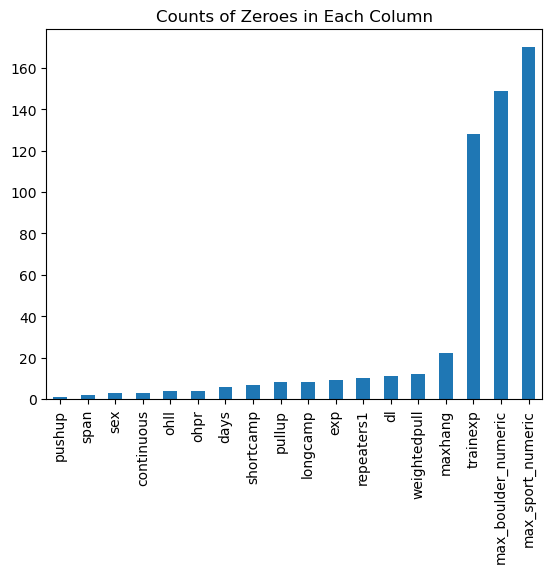

In [47]:
# Count zero values and filter columns with more than 0 zeroes
zero_counts = (data == 0).sum()
zero_counts = zero_counts[zero_counts > 0]

# Sort counts in ascending order
zero_counts.sort_values(inplace=True)

# Calculate percentage of total values that are zero for each column
total_rows = len(data)
zero_percentage = (zero_counts / total_rows) * 100

# Count NaN values in each column
nan_counts = data.isna().sum()

# Print and plot
print("Total rows:")
print(total_rows)
print("Counts of zeroes:")
print(zero_counts)
print("\nPercentage of zeroes:")
print(zero_percentage)
print("\nCounts of NaNs:")
print(nan_counts)

# Create bar plot for zero counts
zero_counts.plot.bar()
plt.title('Counts of Zeroes in Each Column')
plt.show()


In [48]:
# Drop rows where 'max_boulder_numeric' or 'max_sport_numeric' is NaN
data_clean = data.dropna(subset=['max_boulder_numeric', 'max_sport_numeric'])

# Drop rows where 'max_boulder_numeric' or 'max_sport_numeric' is 0
data_clean = data_clean[(data_clean['max_boulder_numeric'] != 0) & (data_clean['max_sport_numeric'] != 0)]

In [49]:
# Use the .describe() function to generate descriptive statistics of the dataframe.
# This includes central tendency, dispersion and shape of the dataset’s distribution.
data_clean.describe()

age         sex         exp    trainexp      season        days  \
count  374.000000  374.000000  373.000000  373.000000  370.000000  364.000000   
mean    32.852941    1.251337    4.187668    1.949062    2.735135    4.899038   
std      7.635270    0.469939    1.680744    1.604791    0.965591    5.080754   
min     16.000000    0.000000    0.000000    0.000000    1.000000    0.416667   
25%     27.000000    1.000000    3.000000    1.000000    2.000000    2.500000   
50%     31.500000    1.000000    4.000000    2.000000    3.000000    3.750000   
75%     37.000000    1.750000    6.000000    3.000000    4.000000    6.250000   
max     60.000000    3.000000    6.000000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  371.000000  374.000000  356.000000  368.000000  ...  198.000000   
mean   174.366071   69.527136  177.848945   15.160326  ...  132.775455   
std     10.898747   10.482807   38.722721    6.635209  ...   98.795371   
min    147.320000   43.091275    0.000000    0.000000  ...    0.000000   
25%    167.640000   63.502932  168.910000   11.000000  ...   74.250000   
50%    175.260000   69.399633  177.800000   15.000000  ...  106.500000   
75%    180.340000   76.657111  185.420000   18.000000  ...  155.750000   
max    281.940000  130.634603  482.600000   50.000000  ...  662.000000   

             ohpr        ohll          dl   bmi_score  \
count  146.000000  146.000000  142.000000  369.000000   
mean    20.778259   20.267501  105.211070   22.771003   
std      6.619280    6.744094   44.156465    2.506437   
min      0.000000    0.000000    0.000000    8.700000   
25%     15.875733   15.875733   79.945655   21.500000   
50%     20.865249   20.411657  107.728188   22.700000   
75%     24.947580   24.947580  136.077711   23.900000   
max     37.194574   37.194574  272.155422   41.300000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 364.000000                     361.000000   
mean                    1.672749                       2.486694   
std                     0.301698                       0.645241   
min                     1.000000                       1.000000   
25%                     1.483436                       2.030892   
50%                     1.652112                       2.490679   
75%                     1.823259                       2.925628   
max                     3.232143                       4.436306   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  353.000000         374.000000           374.000000  
mean                     2.172825           9.818182             5.770053  
std                      0.636917           3.415638             2.399857  
min                      1.000000           1.000000             1.000000  
25%                      1.718359           9.000000             4.000000  
50%                      2.139159           9.000000             6.000000  
75%                      2.553399          13.000000             7.000000  
max                      4.702795          19.000000            14.000000  

[8 rows x 26 columns]

This piece of the script is used for detecting and removing outliers in the dataset. It allows me to see what the median, min, and max values are to help decide which columns have significant outliers.

In [50]:
# Columns for outlier removal based on 'min' and 'max' fields
cols_to_consider = ['height', 'weight', 'span']

# Fill NaNs for Z-score calculation
data_clean[cols_to_consider] = data_clean[cols_to_consider].fillna(data_clean[cols_to_consider].mean())

# Calculate absolute Z-scores
abs_z_scores = np.abs(stats.zscore(data_clean[cols_to_consider]))

# Identify non-outliers (within 3 standard deviations)
non_outlier_mask = (abs_z_scores < 3).all(axis=1)

# Remove outliers
data_clean = data_clean[non_outlier_mask]

# Descriptive statistics after outlier removal
data_clean.describe()

age         sex         exp    trainexp      season        days  \
count  362.000000  362.000000  361.000000  361.000000  358.000000  352.000000   
mean    32.712707    1.251381    4.177285    1.941828    2.731844    4.871922   
std      7.531673    0.471117    1.678834    1.589705    0.961816    5.136760   
min     16.000000    0.000000    0.000000    0.000000    1.000000    0.416667   
25%     27.000000    1.000000    3.000000    1.000000    2.000000    2.500000   
50%     31.000000    1.000000    4.000000    2.000000    3.000000    3.750000   
75%     37.000000    1.750000    6.000000    3.000000    4.000000    6.250000   
max     60.000000    3.000000    6.000000    6.000000    4.000000   75.000000   

           height      weight        span      pullup  ...   shortcamp  \
count  362.000000  362.000000  362.000000  357.000000  ...  191.000000   
mean   174.027708   69.196807  177.149476   15.123249  ...  131.714869   
std      9.218706    9.996607   10.696089    6.314015  ...   94.152313   
min    147.320000   43.091275  147.320000    0.000000  ...    0.000000   
25%    167.640000   62.595747  170.180000   11.000000  ...   75.000000   
50%    174.673335   69.399633  177.800000   15.000000  ...  110.000000   
75%    180.340000   76.203518  185.420000   18.000000  ...  155.500000   
max    194.056000   98.883137  205.740000   50.000000  ...  662.000000   

             ohpr        ohll          dl   bmi_score  \
count  138.000000  138.000000  134.000000  357.000000   
mean    20.783076   20.275579  106.008599   22.708123   
std      6.622851    6.648309   43.237080    2.161945   
min      0.000000    0.000000    0.000000   12.800000   
25%     15.875733   15.875733   81.646627   21.400000   
50%     20.638453   20.411657  108.862169   22.700000   
75%     24.947580   24.834182  136.077711   23.800000   
max     37.194574   37.194574  272.155422   34.000000   

       strength_to_weight_pullup  strength_to_weight_weightpull  \
count                 353.000000                     350.000000   
mean                    1.670793                       2.491808   
std                     0.287856                       0.641951   
min                     1.000000                       1.000000   
25%                     1.485830                       2.057568   
50%                     1.654206                       2.498653   
75%                     1.814480                       2.929042   
max                     3.164502                       4.436306   

       strength_to_weight_maxhang  max_sport_numeric  max_boulder_numeric  
count                  341.000000         362.000000           362.000000  
mean                     2.178652           9.806630             5.787293  
std                      0.637855           3.385837             2.404187  
min                      1.000000           1.000000             1.000000  
25%                      1.724044           9.000000             4.000000  
50%                      2.144384           9.000000             6.000000  
75%                      2.556444          13.000000             7.000000  
max                      4.702795          19.000000            14.000000  

[8 rows x 26 columns]

In [51]:
# Define columns of interest
cols_of_interest = ["age", "sex", "max_boulder_numeric", "max_sport_numeric",
                    "exp", "trainexp", "season", "days",
                    "height", "weight", "span", "pullup", "pushup", "continuous",
                    "maxhang", "weightedpull", "repeaters1", "longcamp",
                    "ohpr", "ohll", "dl", "shortcamp", "bmi_score",
                    "strength_to_weight_pullup", "strength_to_weight_weightpull",
                    "strength_to_weight_maxhang"]

# Create a filtered copy with only the columns of interest
data_filtered = data_clean[cols_of_interest].copy()

# Verify all columns are numerical
assert all(data_filtered.dtypes != 'object'), "All columns should be numerical"

# Filter relevant rows for bouldering and sport climbing
data_filtered_bouldering = data_filtered.query('max_boulder_numeric != 0')
data_filtered_sport = data_filtered.query('max_sport_numeric != 0')


In [52]:
# To check the total number of rows and columns in your DataFrame
total_rows, total_columns = data_filtered_bouldering.shape

# To check just the total number of rows
total_rows = len(data_filtered_bouldering)

# To print these values
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 362
Total number of columns: 26


In [53]:
# To check the total number of rows and columns in your DataFrame
total_rows, total_columns = data_filtered_sport.shape

# To check just the total number of rows
total_rows = len(data_filtered_sport)

# To print these values
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 362
Total number of columns: 26


In this part of the script, a new dataset data_filtered is created, keeping only the numerical fields of interest from the original data dataframe. This is done because the models I am using only accept numerical input.

The creation of the two separate datasets, data_filtered_bouldering and data_filtered_sport, is meant to differentiate between data relevant for bouldering and sport climbing. This is because climbers may have different levels of abilities and experience in these two different types of climbing. As such, it is better to create separate models for each type to more accurately capture the relevant information.

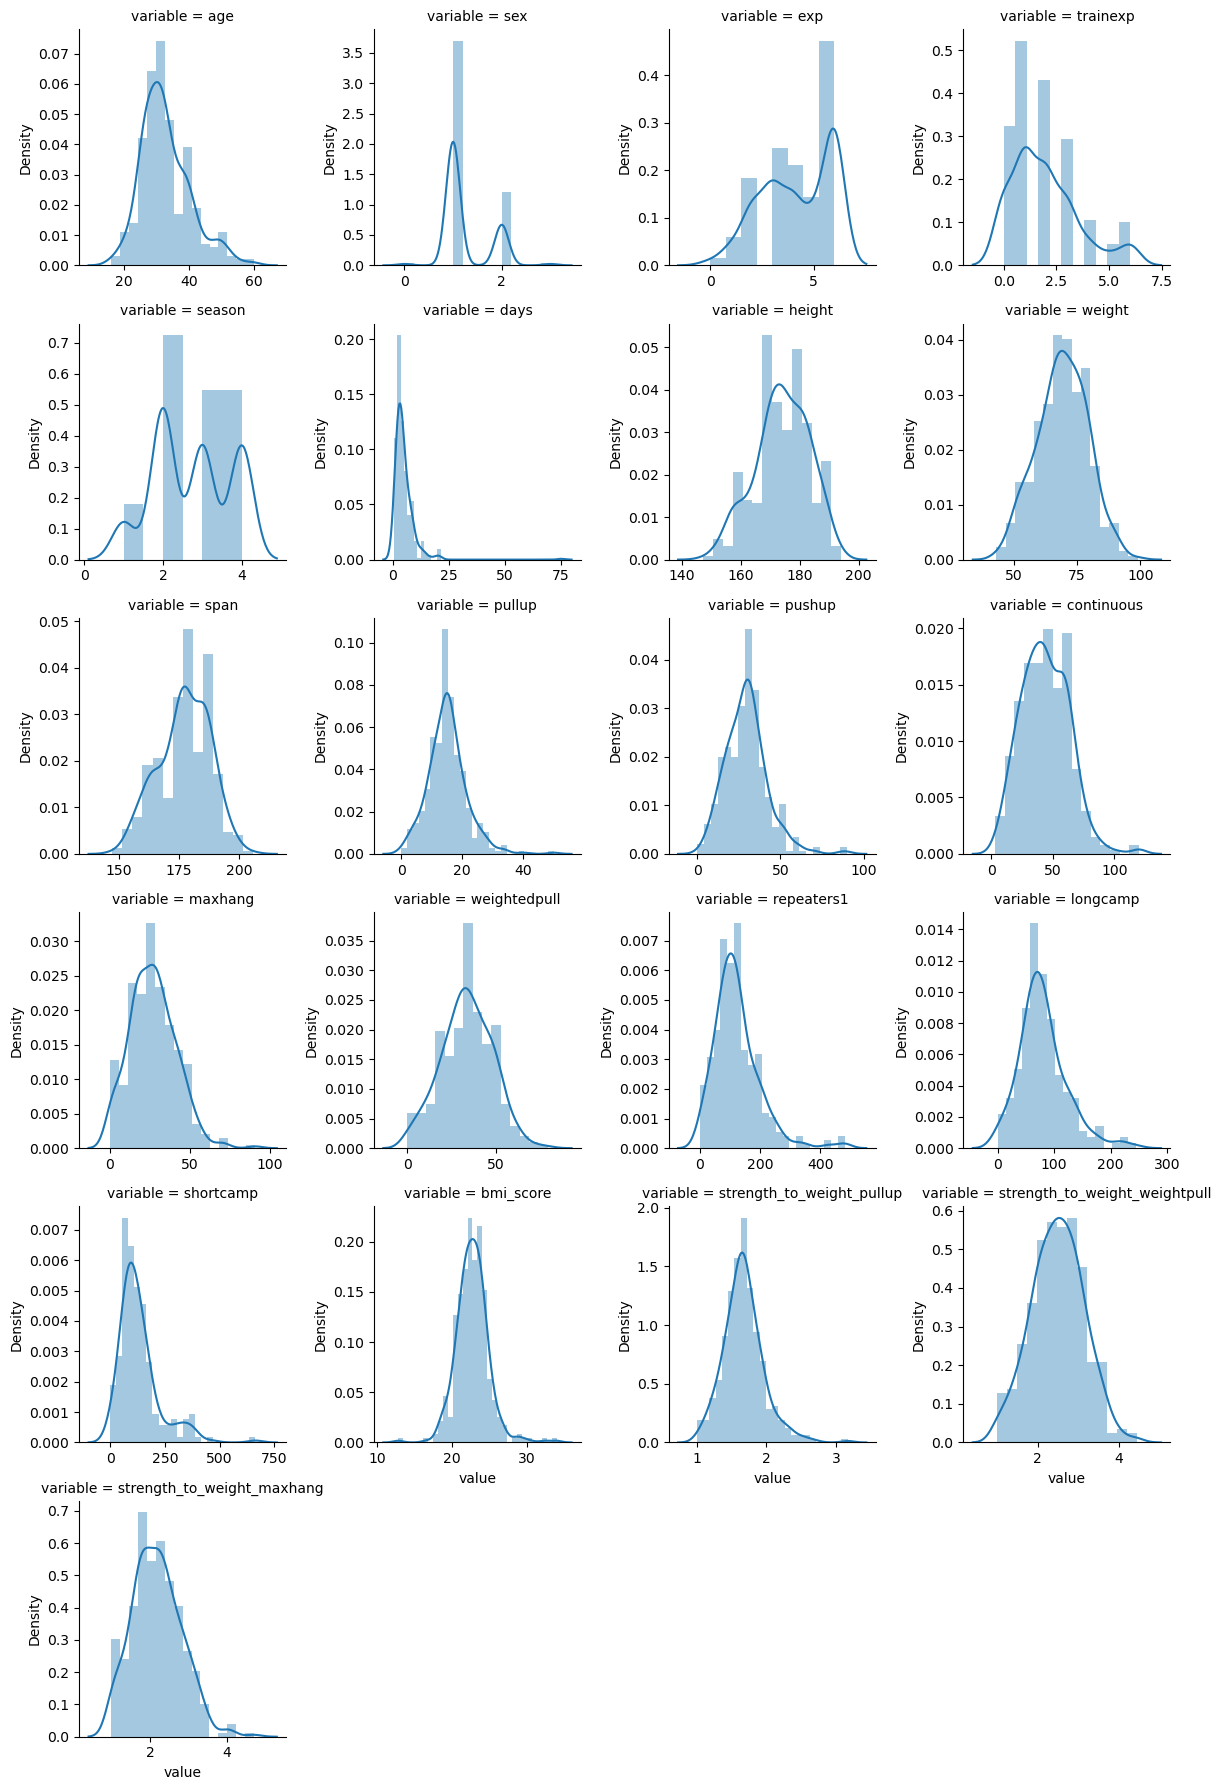

In [54]:
# Select all the features of interest from the bouldering data
all_feat_bouldering = data_filtered_bouldering[["age", "sex", "exp", "trainexp", "season", "days",
                                                "height", "weight", "span", "pullup", "pushup", "continuous",
                                                "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                                "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                                "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# Melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered, value_vars=all_feat_bouldering)

# Create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# Use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

In this part of the script, the distribution of each variable in the data_filtered_bouldering dataframe is plotted to check if they follow a normal distribution. This is done using the seaborn library's FacetGrid and distplot functions, which create a grid of histograms for each variable.

From these plots, we can assess the distribution of each variable. If a variable's distribution significantly deviates from a normal distribution (e.g., if it is heavily skewed), it may need to be transformed (e.g., by taking the logarithm) before being used in a machine learning model.

The same is done below for the sport climbing dataset.

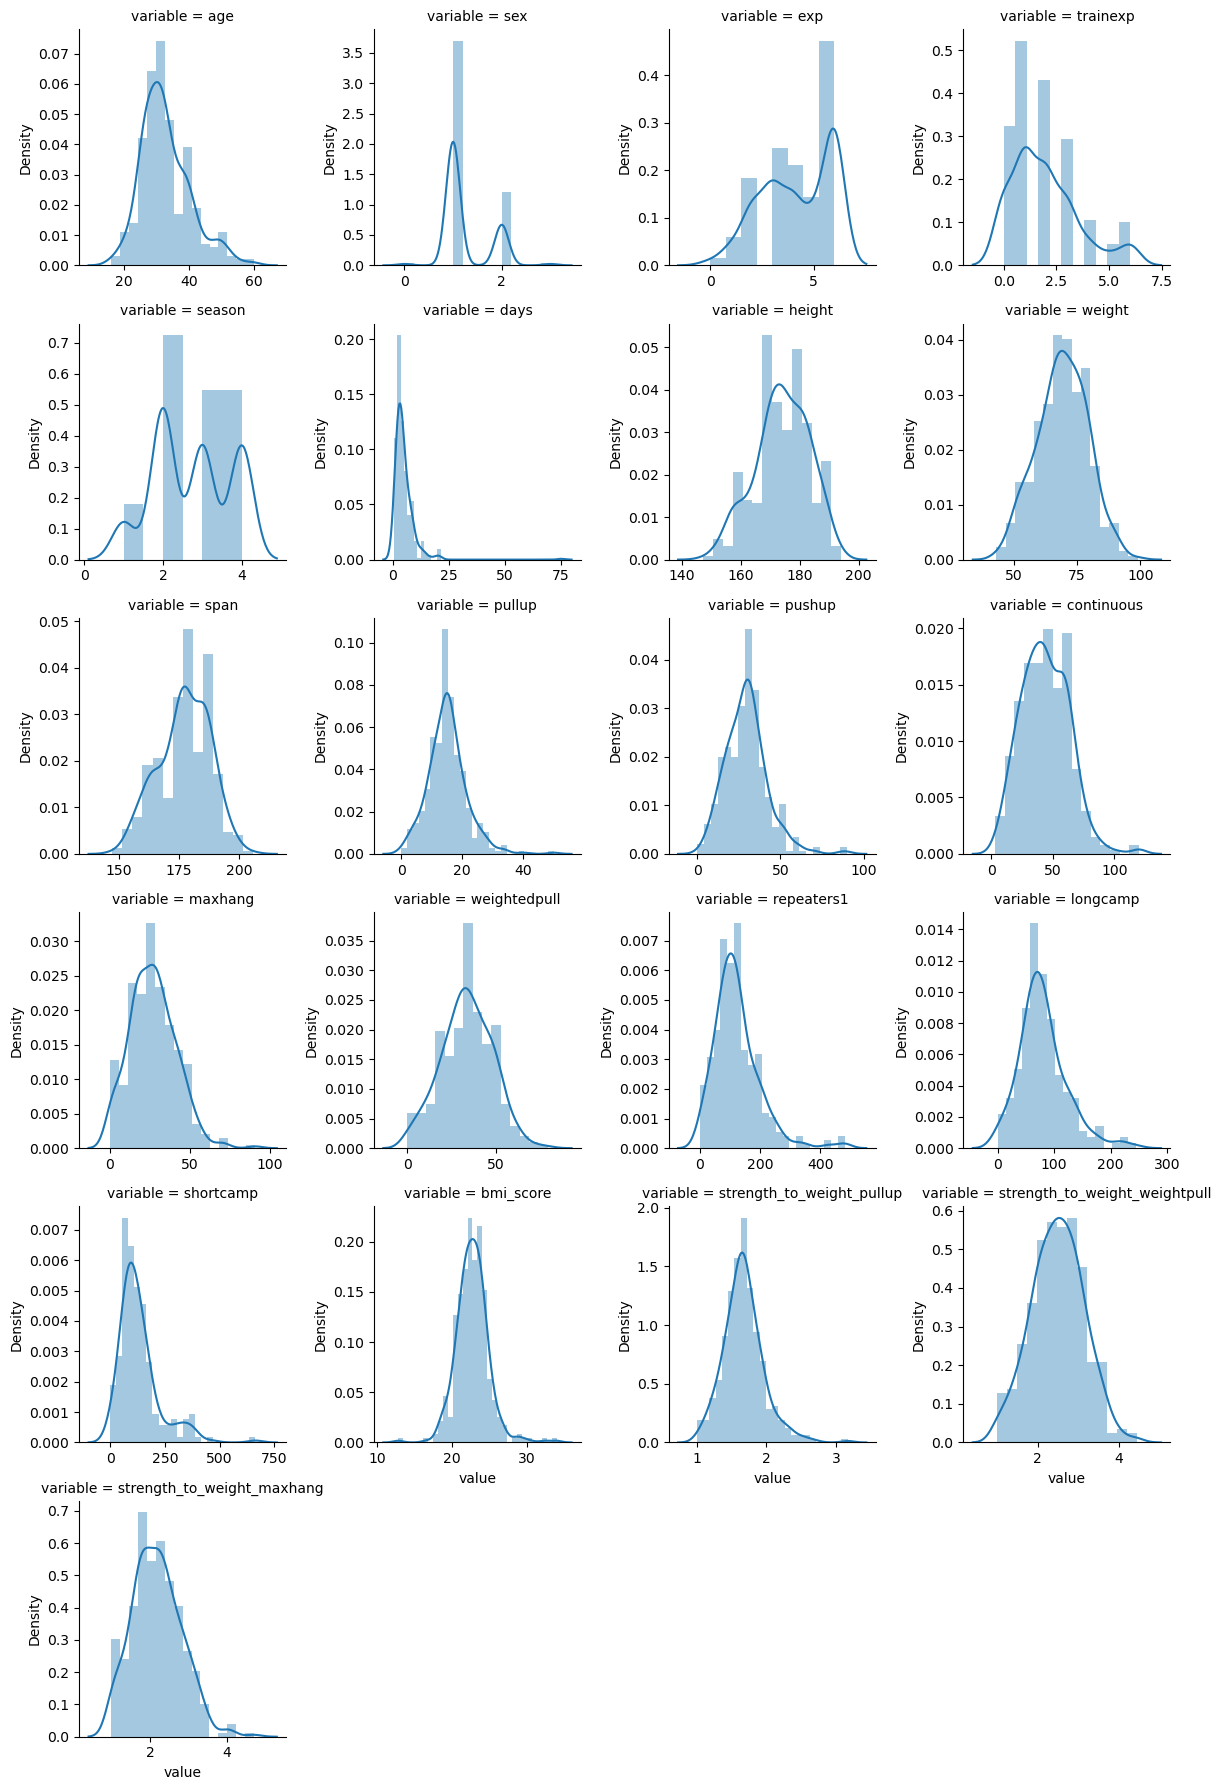

In [55]:
# Select all the features of interest from the sport climbing data
all_feat_sport = data_filtered_sport[["age", "sex", "exp", "trainexp", "season", "days",
                                      "height", "weight", "span", "pullup", "pushup", "continuous",
                                      "maxhang", "weightedpull", "repeaters1", "longcamp", 
                                      "shortcamp", "bmi_score", "strength_to_weight_pullup",
                                      "strength_to_weight_weightpull", "strength_to_weight_maxhang"]]

# Melt the data to a long format where each row is a unique variable-value pair.
f = pd.melt(data_filtered, value_vars=all_feat_sport)

# Create a FacetGrid, which is a multi-plot grid for plotting conditional relationships.
g = sns.FacetGrid(f, col="variable", col_wrap=4, sharex=False, sharey=False)

# Use the map function to plot a distribution plot for each variable on the FacetGrid.
g = g.map(sns.distplot, "value")

By visualizing the distribution of each variable, we can gain insights about the structure of the data and identify any potential anomalies (e.g., a variable that has a single, dominant value), outliers, or trends that might warrant further investigation.

**Results**
All the variables look normally distributed.

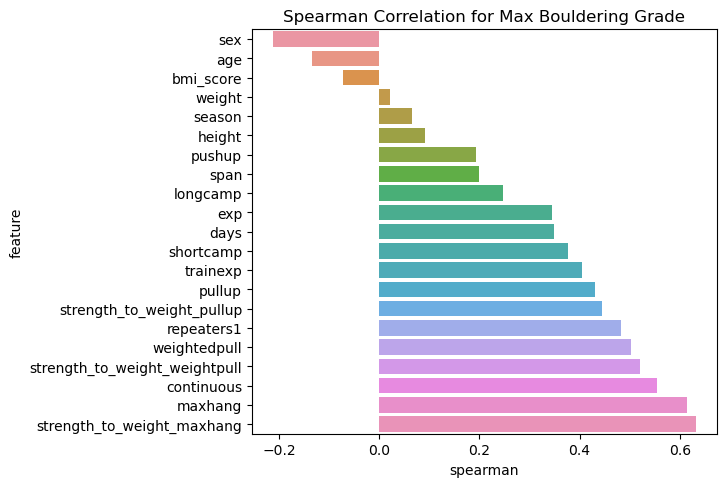

In [56]:
# Spearman analysis for bouldering
def spearman(frame, features):
    # Create an empty DataFrame
    spr = pd.DataFrame()

    # Add a 'feature' column that contains all feature names
    spr['feature'] = features

    # Add a 'spearman' column that contains the Spearman correlation of each feature with the max_boulder_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_boulder_numeric'], 'spearman') for f in features]

    # Sort the DataFrame by the 'spearman' column
    spr = spr.sort_values('spearman')

    # Create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Bouldering Grade')

# Call the function with the bouldering data
features = all_feat_bouldering.columns.tolist()
spearman(data_filtered_bouldering, features)

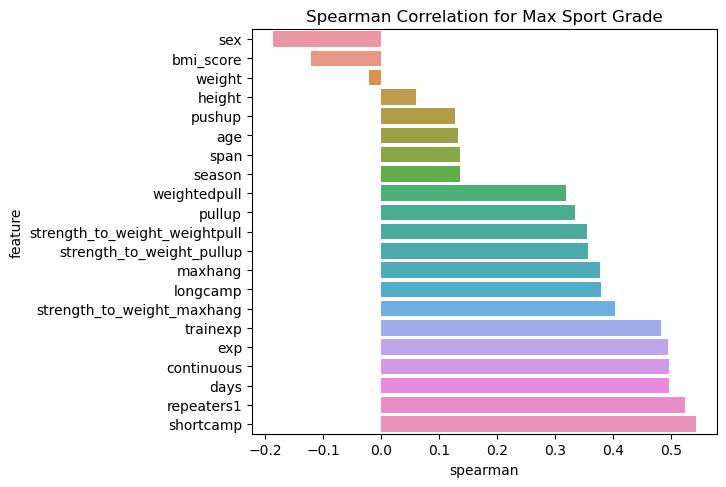

In [57]:
# Spearman analysis for sport climbing
def spearman(frame, features):
    # Create an empty DataFrame
    spr = pd.DataFrame()

    # Add a 'feature' column that contains all feature names
    spr['feature'] = features

    # Add a 'spearman' column that contains the Spearman correlation of each feature with the max_boulder_numeric feature
    spr['spearman'] = [frame[f].corr(frame['max_sport_numeric'], 'spearman') for f in features]

    # Sort the DataFrame by the 'spearman' column
    spr = spr.sort_values('spearman')

    # Create a bar plot of the Spearman correlations
    plt.figure(figsize=(6, 0.25 * len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    plt.title('Spearman Correlation for Max Sport Grade')

# Call the function with the bouldering data
features = all_feat_sport.columns.tolist()
spearman(data_filtered_sport, features)

Here, two Spearman correlation analyses are being performed: one for bouldering and one for sport climbing. The Spearman correlation coefficient measures the strength and direction of monotonic relationship between two variables, without making any assumptions about the distributions of the variables.

Spearman's rank correlation coefficient is a non-parametric test that is used to measure the degree of association between two variables. It is a measure of a monotonic relationship (either increasing or decreasing, but not necessarily at a constant rate) between paired data.

In this context, it is used to evaluate the relationship between each feature (age, sex, experience, etc.) and the maximum bouldering/sport climbing grades.

In the barcharts, features that have a strong positive Spearman correlation with the target variable are good predictors for higher climbing grades, while those with a strong negative correlation are good predictors for lower grades.

**Results**

Sex, BMI, Height, Age and Weight are all of a low/negative correlation for both sport climbing and bouldering. Interestingly there are some differences between the most correlated features, but somewhat expected.

Bouldering max grade tends to favour raw power so we can see strength to weight max hangs/weighted pullups/pullups all in the top 5, with continuous hanging from a 20mm edge taking 3rd place. 

For sport climbing, none of these pure power metrics are in the top 5, with more endurance based metrics taking the top spots: repeaters, continuous hangs and short camp.

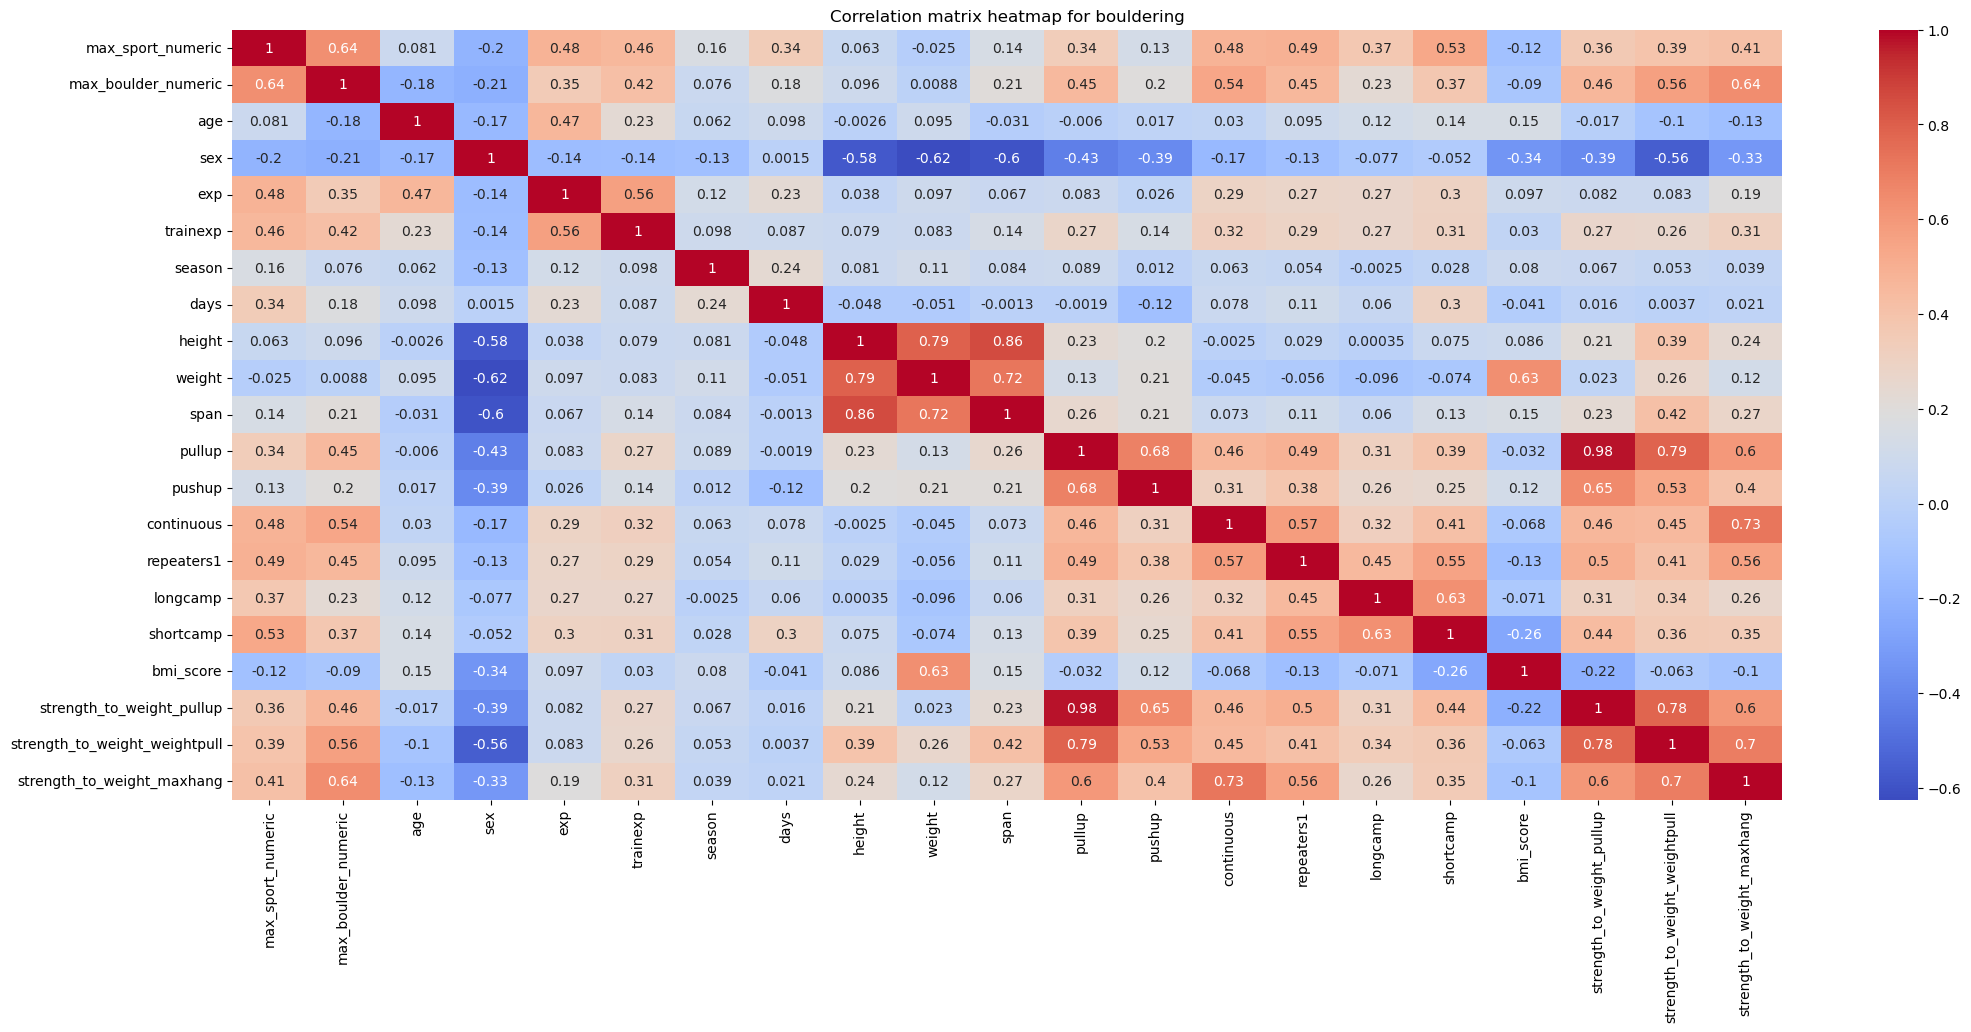

In [58]:
# Calculate the correlation matrix for the specified columns in the bouldering data
corr = data_filtered_bouldering[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# Create a new figure with a specified size
plt.figure(figsize=(25, 10))

# Create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title("Correlation matrix heatmap for bouldering")

# Show the plot
plt.show()

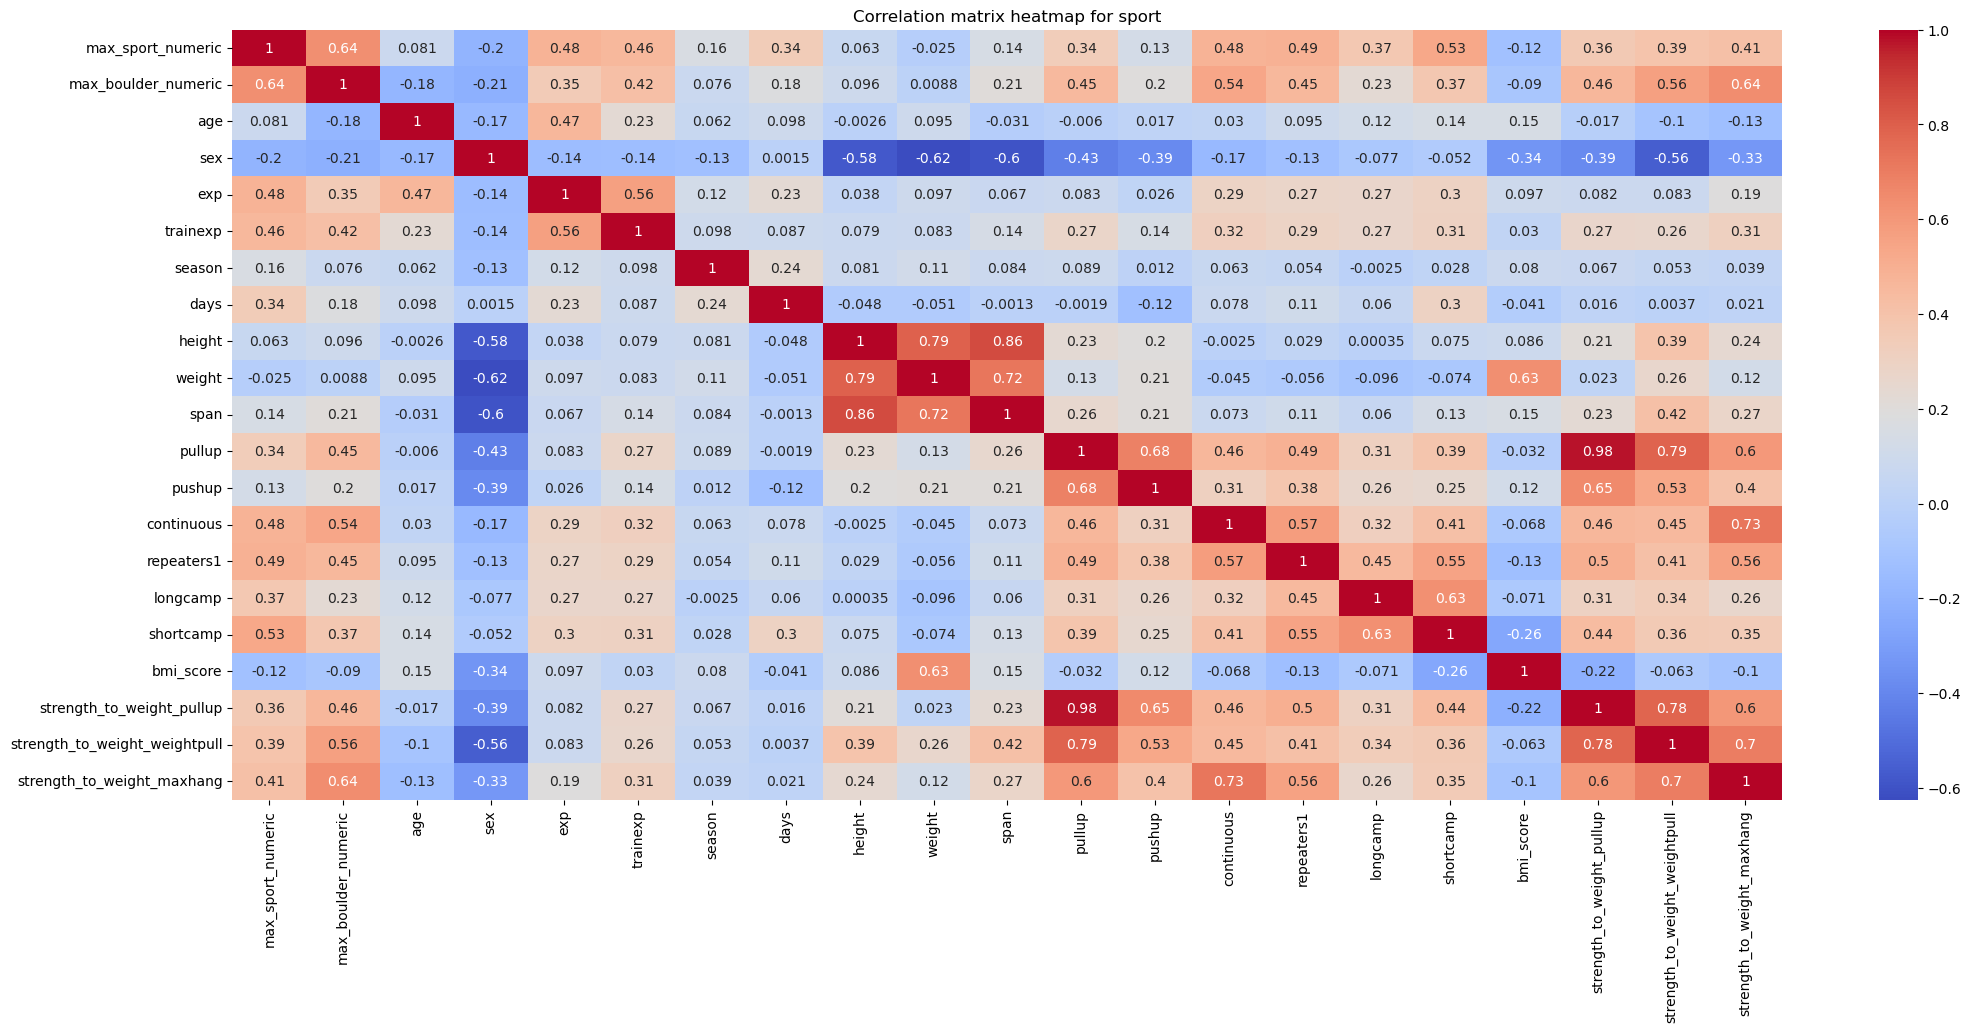

In [59]:
# Calculate the correlation matrix for the specified columns in the sport data
corr = data_filtered_sport[[
    "max_sport_numeric", "max_boulder_numeric", "age", "sex", "exp", "trainexp",
    "season", "days", "height", "weight", "span", "pullup", "pushup", "continuous",
    "repeaters1", "longcamp", "shortcamp", "bmi_score", "strength_to_weight_pullup",
    "strength_to_weight_weightpull", "strength_to_weight_maxhang"
]].corr()

# Create a new figure with a specified size
plt.figure(figsize=(25, 10))

# Create a heatmap of the correlation matrix
# 'annot=True' makes the correlation values visible on the heatmap
# 'cmap' sets the color map to 'coolwarm', which is a diverging colormap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Set the title of the plot
plt.title("Correlation matrix heatmap for sport")

# Show the plot
plt.show()

The correlation matrix is calculated using the .corr() method, which calculates the pairwise correlation of columns. Correlation indicates how strongly two variables are related to each other.

The .corr() method computes the correlation coefficient, a statistical measure that calculates the strength of the relationship between the relative movements of two variables. The range of values for the correlation coefficient is -1.0 to 1.0. A correlation of -1.0 shows a perfect negative correlation, while a correlation of 1.0 shows a perfect positive correlation. A correlation of 0.0 shows no linear relationship between the movement of the two variables.

In the heatmaps, a darker color in either direction (dark blue or dark red) indicates a stronger correlation. A positive correlation (red) means that as one variable increases, the other tends to increase as well. A negative correlation (blue) means that as one variable increases, the other tends to decrease. The stronger the color, the stronger the correlation.

**Results**

We are seeing similar results to our Spearman analysis which is good since this essentially double checks our initial results analysis.

Text(0.5, 0.98, 'Max Bouldering')

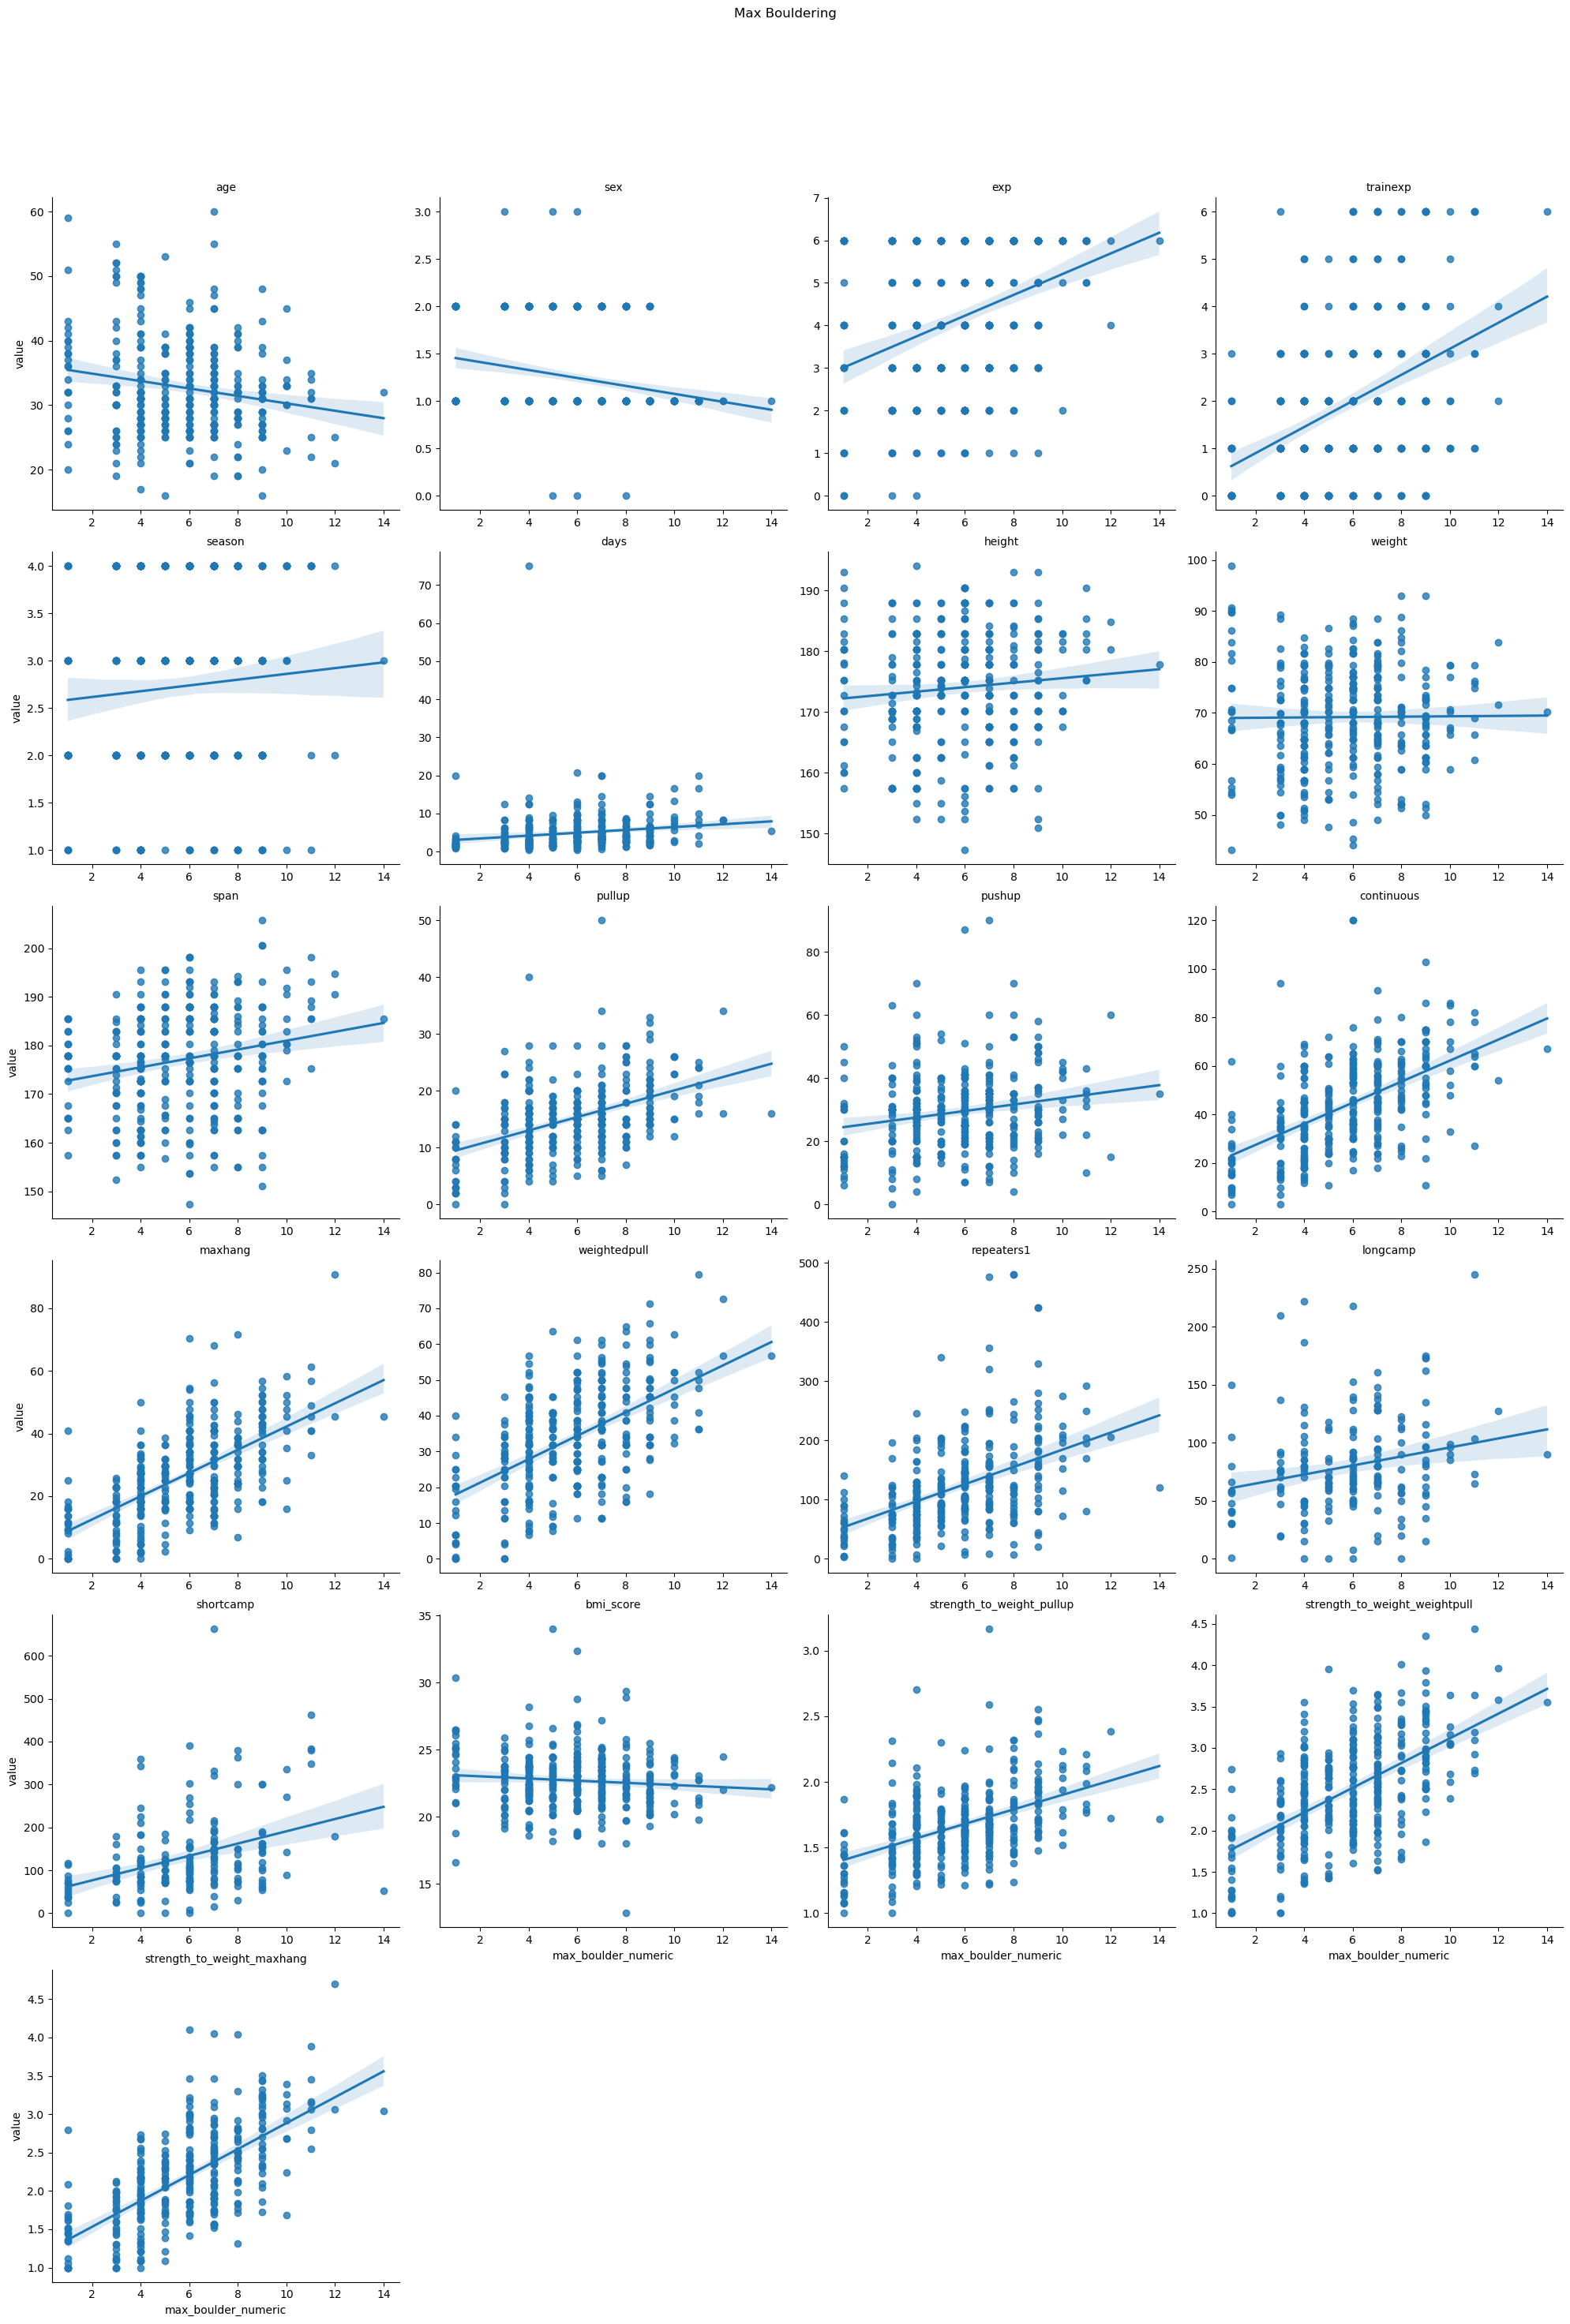

In [60]:
# Melt the DataFrame, keeping 'max_boulder_numeric' fixed and converting the columns in 'all_feat_bouldering' into a single column
f = pd.melt(data_filtered_bouldering, id_vars=['max_boulder_numeric'], value_vars=all_feat_bouldering)

# Create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# Map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_boulder_numeric", "value").set_titles("{col_name}")

# Adjust the top margin to make room for the title
plt.subplots_adjust(top=0.9)

# Set the title for the entire figure
g.fig.suptitle('Max Bouldering')

Text(0.5, 0.98, 'Max Sport')

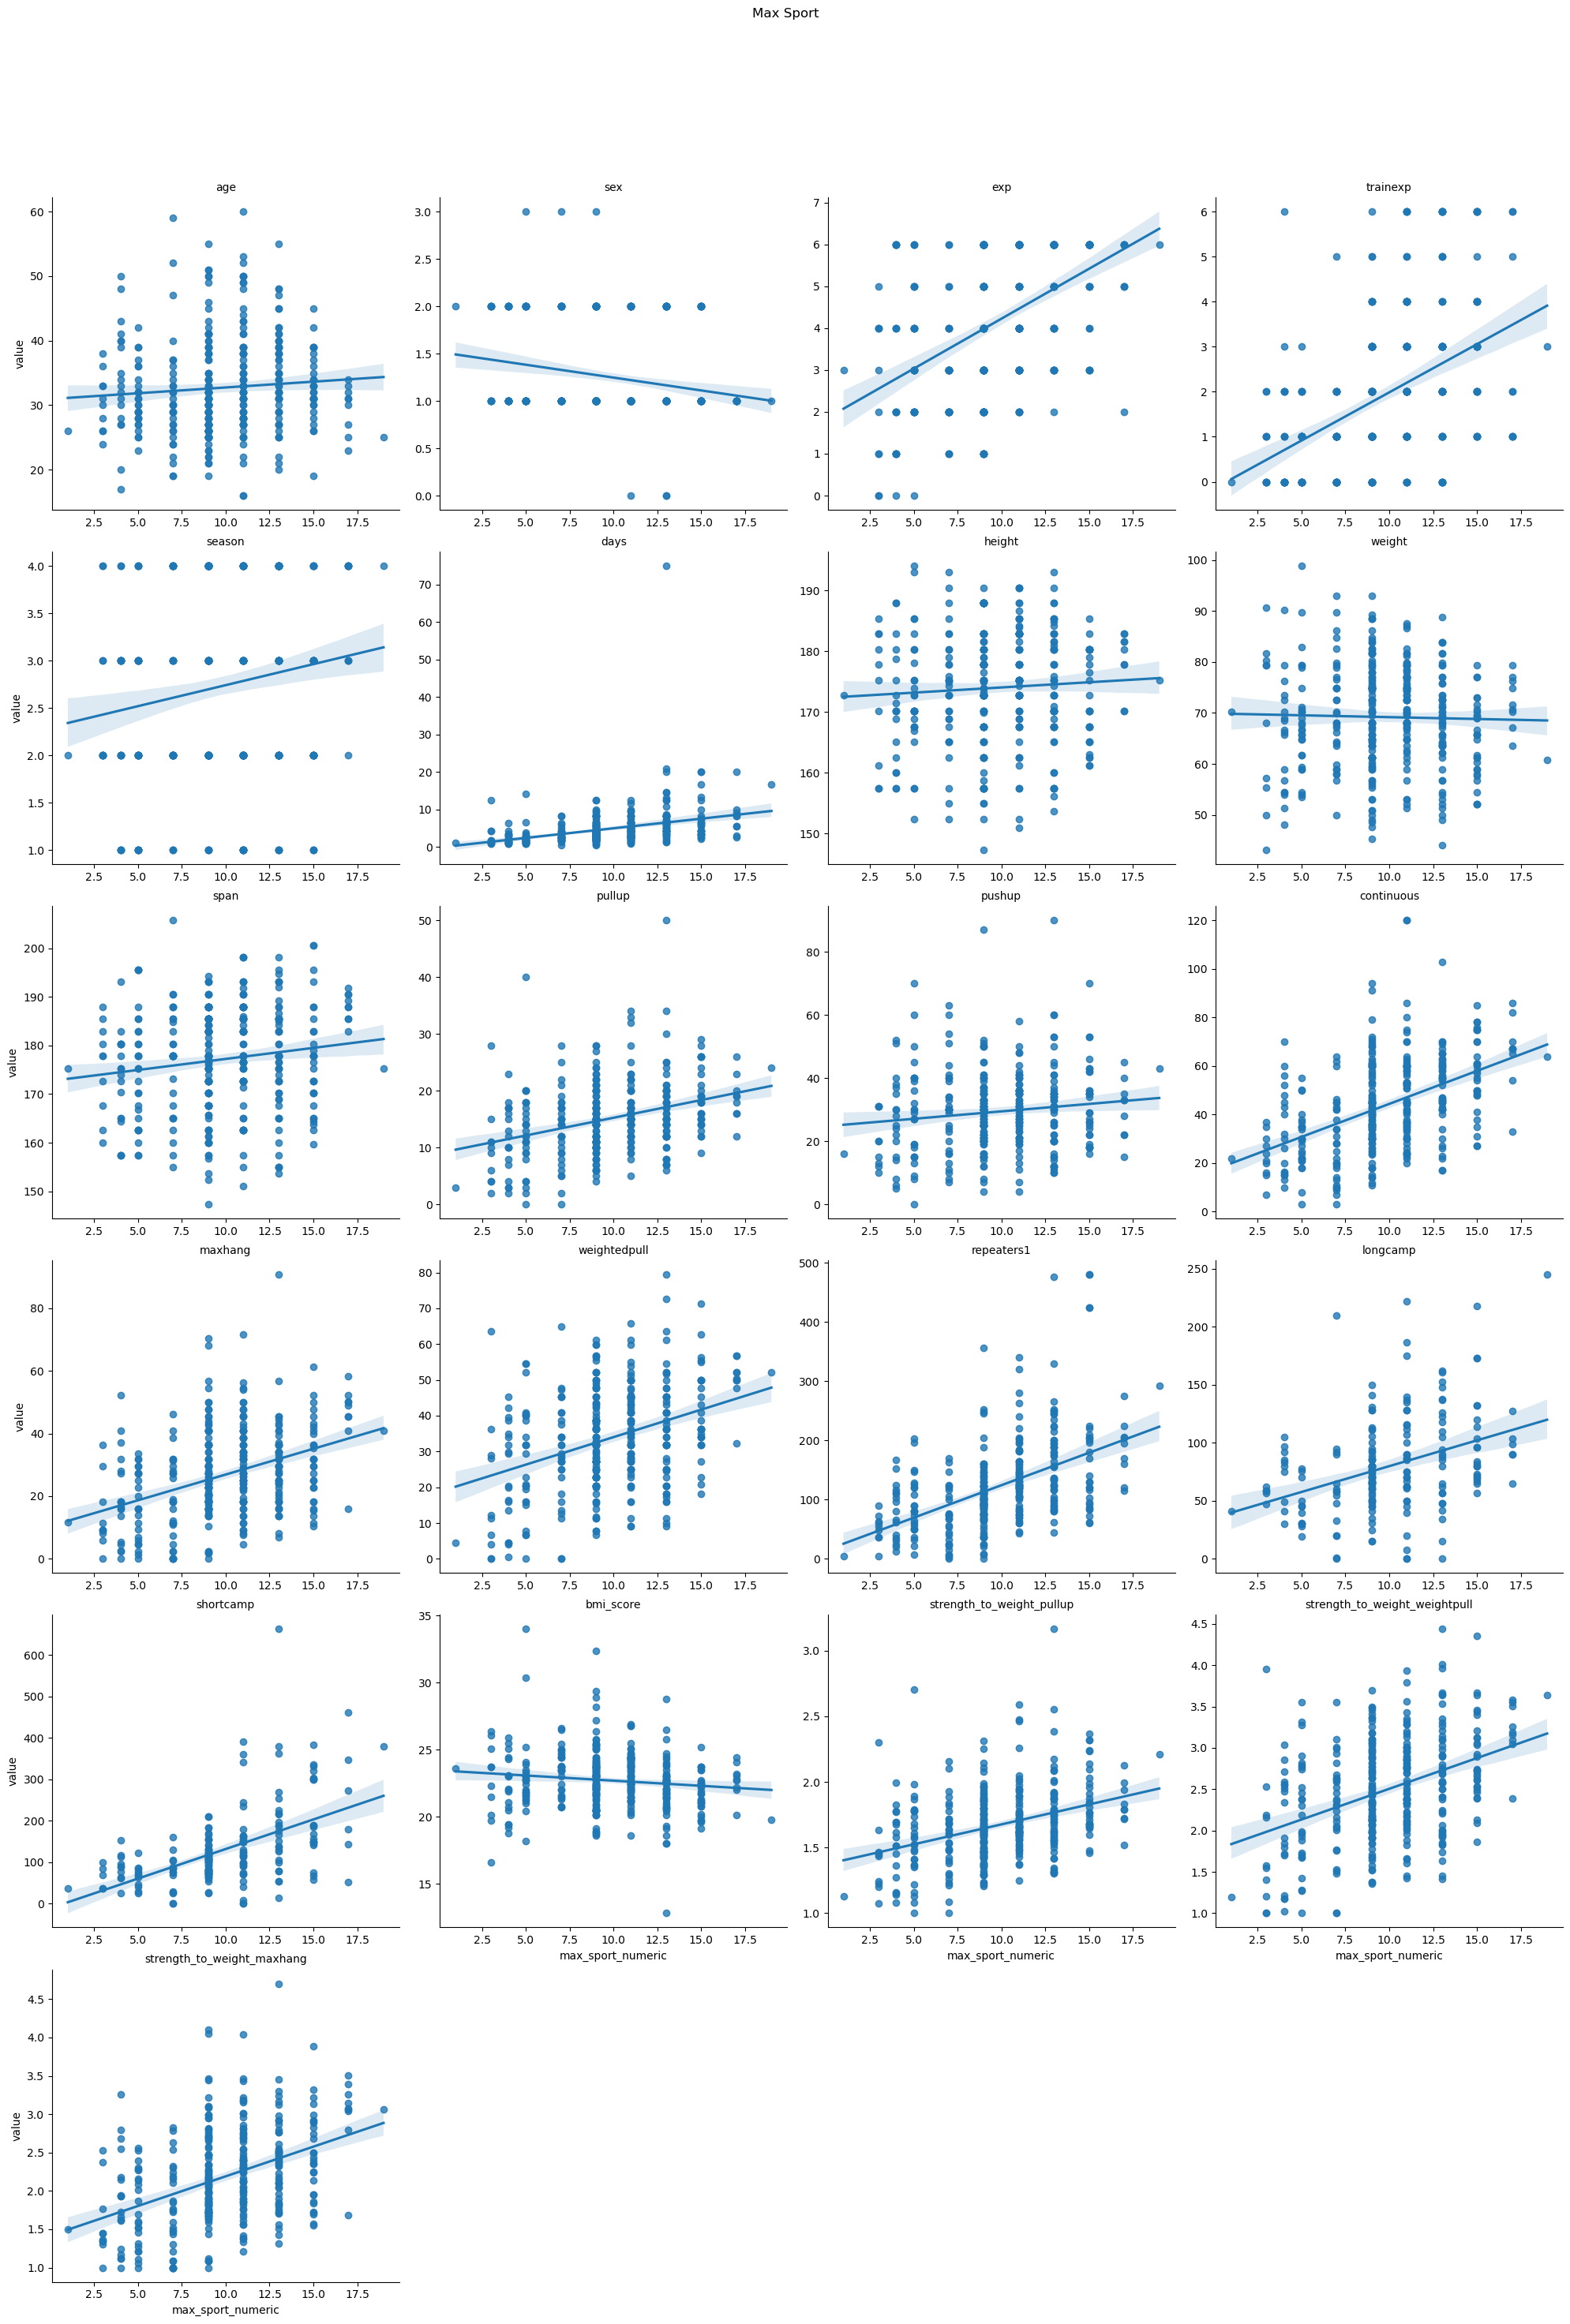

In [61]:
# Melt the DataFrame, keeping 'max_sport_numeric' fixed and converting the columns in 'all_feat_sport' into a single column
f = pd.melt(data_filtered_sport, id_vars=['max_sport_numeric'], value_vars=all_feat_sport)

# Create a FacetGrid object with a subplot for each feature in 'all_feat_bouldering'
g = sns.FacetGrid(f, col="variable",  col_wrap=4, sharex=False, sharey=False, height=5)

# Map a regplot to each subplot, plotting 'max_boulder_numeric' against the feature values
g = g.map(sns.regplot, "max_sport_numeric", "value").set_titles("{col_name}")

# Adjust the top margin to make room for the title
plt.subplots_adjust(top=0.9)

# Set the title for the entire figure
g.fig.suptitle('Max Sport')

The graphs above are another way of representing the relationships between each feature and the max bouldering/sport climbing grades. The trend lines are calculated using regression, which attempts to draw a straight line to indicate the relationship between the variable the max_sport/bouldering_grade

In [62]:
# Define the independent variables for bouldering based on the above results
# Exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_bouldering = ['strength_to_weight_pullup', 'strength_to_weight_maxhang',
                    'strength_to_weight_weightpull', 'continuous', 'shortcamp', 'longcamp', 'repeaters1','pushup','span', 'exp','days', 'trainexp']

In [63]:
# Fit a regression model for max_boulder_numeric

# Drop rows with missing values first
data_filtered_bouldering = data_filtered_bouldering.dropna(subset=['max_boulder_numeric'] + independent_vars_bouldering)
# Then define X_boulder and Y_boulder
X_boulder = sm.add_constant(data_filtered_bouldering[independent_vars_bouldering])
Y_boulder = data_filtered_bouldering['max_boulder_numeric']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_boulder, Y_boulder, test_size=0.2, random_state=42)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)

# Print Ridge Regression MSE
print(f'Ridge Regression MSE: {mean_squared_error(Y_test, Y_pred_ridge)}')

# Create a dictionary to map coefficients to their corresponding variable names
coef_dict = {}
for coef, feat in zip(ridge.coef_,X_train.columns):
    coef_dict[feat] = coef

# Print the dictionary
print("Ridge Regression Coefficients:")
for feat, coef in coef_dict.items():
    print(f"{feat}: {coef}")

2023/10/22 22:13:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'e00b881a5e674dd3b6c514d63a4aae9a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/22 22:13:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpve_kdxsy/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


Ridge Regression MSE: 3.910751319381388
Ridge Regression Coefficients:
const: 0.0
strength_to_weight_pullup: 0.5786185624280276
strength_to_weight_maxhang: 0.49577467696032024
strength_to_weight_weightpull: 1.0361145745320168
continuous: 0.04244654400404724
shortcamp: -0.0014248890630515103
longcamp: 0.0018154480175123413
repeaters1: 0.0007508100481168233
pushup: -0.018190280631918066
span: 0.0031056880026002942
exp: 0.1601304359235045
days: 0.13553738294727682
trainexp: 0.07669382291897882


In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_boulder.columns

# Note that the first column is for the 'const' term, so we skip it
vif_data["VIF"] = [variance_inflation_factor(X_boulder.values, i) for i in range(len(X_boulder.columns))]

print(vif_data)

2023/10/22 22:13:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '3434b391b60d44d3bdce6a585a5610fb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/10/22 22:13:55 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp8f4rev55/model, flavor: statsmodels), fall back to return ['statsmodels==0.13.5']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:13:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '184d6d8a07834778b13495b52961734b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow
2023/10/22 22:13:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp3gqsro6m/model, flavor: statsmodels), fall back to return ['statsmodels==0.13.5']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:13:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID

                          feature         VIF
0                           const  431.565692
1       strength_to_weight_pullup    4.463808
2      strength_to_weight_maxhang    4.018554
3   strength_to_weight_weightpull    4.857897
4                      continuous    2.768360
5                       shortcamp    2.388099
6                        longcamp    1.937527
7                      repeaters1    2.102375
8                          pushup    2.165790
9                            span    1.477434
10                            exp    1.638429
11                           days    1.244006
12                       trainexp    1.655098


**Results**

strength_to_weight_pullup comes out on top although it's not statistically significant according to the regression analysis, strength_to_weight_maxhang in second place with the highest coefficient and also statistically significant. strength_to_weight_weightpull is not far behind although it's coefficient is almost half of the maxhangs. Interestingly pushups has a negative coefficient... so if you want to send hard, stop doing pushups (note: this is a joke, and probably just a result of the dataset rather than truth).

Interestingly this leaves out strength_to_weight_pullup, which also has the highest coefficient of 1.24, basically saying that for each one-unit increase in strength_to_weight_pullup, the max bouldering grade is estimated to increase by 1.24. Even with a p-value of 0.14 (meaning our confidence is only 76%), I think we can include this value in our analysis as we know that pullups are important in climbing performance.

Based on these regression results I am choosing the variables to include in the model as strength_to_weight_maxhang, strength_to_weight_pullup, strength_to_weight_weightedpull, and strength_to_weight_continuous.

*Details*

R-squared: The R-squared value is 0.473, indicating that approximately 47.3% of the variability in the dependent variable, max_boulder_numeric, can be explained by the model. This leaves over 50% of the variability unexplained, which suggests that there might be other relevant variables not included in the model.

Adjusted R-squared: The Adjusted R-squared value is slightly lower at 0.455. This statistic adjusts the R-squared value based on the number of predictors in the model. It's a more accurate measure of the goodness-of-fit of the model, particularly when comparing models with different numbers of predictors.

F-statistic and Prob (F-statistic): The F-statistic is used to test the overall significance of the model. The null hypothesis is that all of the regression coefficients are equal to zero. The Prob (F-statistic) value is the probability of obtaining the observed F-statistic, given the null hypothesis is true. In this case, the Prob (F-statistic) is very low (5.18e-28), suggesting that the model is statistically significant, i.e., the model's predictors are not collectively zero.

coef: The coef values are the estimated coefficients of the regression model. They represent the change in the dependent variable for each one-unit change in the predictor, assuming all other predictors are held constant. For example, for every one-unit increase in strength_to_weight_maxhang, the max_boulder_numeric is estimated to increase by 0.7541, assuming all other variables are held constant.

Based on the p-values in the P>|t| column, it appears that strength_to_weight_maxhang, strength_to_weight_weightpull, and pushup are statistically significant predictors in the model (p < 0.05).

The notes at the bottom suggest that there might be multicollinearity in the data, which means that some of the predictor variables are highly correlated with each other. 

I have explored removing some of the variables but the results generally end up around the same. I think this is because there is probably a strong relationship between max hangs, max pullups, continuous etc as someone who is training their max hangs is also likely training their pullups and other climbing metrics.

In [65]:
# Define the independent variables for bouldering based on the above results
# Exclude highly correlated variableslike pullup and strength_to_weight_pullup since one is based on the other
independent_vars_sport = ['strength_to_weight_pullup', 'strength_to_weight_maxhang',
                    'strength_to_weight_weightpull', 'continuous', 'shortcamp', 'longcamp', 'repeaters1','pushup','span', 'exp','days', 'trainexp']

In [66]:
# Fit a regression model for max_boulder_numeric

# Drop rows with missing values first
data_filtered_sport = data_filtered_bouldering.dropna(subset=['max_sport_numeric'] + independent_vars_sport)
# Then define X_boulder and Y_boulder
X_sport = sm.add_constant(data_filtered_sport[independent_vars_sport])
Y_sport = data_filtered_sport['max_sport_numeric']

# Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_sport, Y_sport, test_size=0.2, random_state=42)

# Ridge Regression
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)

# Print Ridge Regression MSE
print(f'Ridge Regression MSE: {mean_squared_error(Y_test, Y_pred_ridge)}')

# Create a dictionary to map coefficients to their corresponding variable names
coef_dict = {}
for coef, feat in zip(ridge.coef_,X_train.columns):
    coef_dict[feat] = coef

# Print the dictionary
print("Ridge Regression Coefficients:")
for feat, coef in coef_dict.items():
    print(f"{feat}: {coef}")

2023/10/22 22:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '929b2176f93242a391ca7cc68b7871cd', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/22 22:13:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpnz5syer9/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


Ridge Regression MSE: 5.099714077781294
Ridge Regression Coefficients:
const: 0.0
strength_to_weight_pullup: 0.32510981667405375
strength_to_weight_maxhang: -1.5335250269933307
strength_to_weight_weightpull: 1.526531540593271
continuous: 0.0702614191102473
shortcamp: 0.0029770529510811214
longcamp: 0.005452709208039913
repeaters1: 0.0072869398138013675
pushup: -0.040406053609592825
span: 0.0179688556988237
exp: 0.46193503970700034
days: 0.2854287470990149
trainexp: 0.0022622523599092137


In [67]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF for each independent variable
vif_data = pd.DataFrame()
vif_data["feature"] = X_sport.columns

# Note that the first column is for the 'const' term, so we skip it
vif_data["VIF"] = [variance_inflation_factor(X_sport.values, i) for i in range(len(X_sport.columns))]

print(vif_data)

2023/10/22 22:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '2e7a4c7342244291b011347a9da8cd67', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


2023/10/22 22:13:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpuvg53aff/model, flavor: statsmodels), fall back to return ['statsmodels==0.13.5']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '618dc76d82e64951ba5c49c24c51d3f3', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow
2023/10/22 22:13:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp5vm32gpx/model, flavor: statsmodels), fall back to return ['statsmodels==0.13.5']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:13:57 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID

                          feature         VIF
0                           const  431.565692
1       strength_to_weight_pullup    4.463808
2      strength_to_weight_maxhang    4.018554
3   strength_to_weight_weightpull    4.857897
4                      continuous    2.768360
5                       shortcamp    2.388099
6                        longcamp    1.937527
7                      repeaters1    2.102375
8                          pushup    2.165790
9                            span    1.477434
10                            exp    1.638429
11                           days    1.244006
12                       trainexp    1.655098


**Results**

strength_to_weight_pullup comes out on top although it's not statistically significant according to the regression analysis, strength_to_weight_weightpull in second place with the highest coefficient and also statistically significant. Interestingly conitnuous and shortcamp which looked like they were important in the Spearman's analysis, have quite a low coefficient.

Based on these regression results I am choosing the variables to include in the model as strength_to_weight_maxhang, strength_to_weight_pullup, strength_to_weight_weightedpull, and strength_to_weight_continuous.

*Details*

R-squared: The R-squared value is 0.434, indicating that approximately 43.4% of the variability in the max_sport_numeric variable can be explained by this model. This suggests there may be other variables not included in this model that could help explain more of the variability.

Adjusted R-squared: The Adjusted R-squared value is slightly lower at 0.415. This measure is generally considered more reliable than R-squared for comparing model fit because it adjusts for the number of predictors in the model.

F-statistic and Prob (F-statistic): The F-statistic is 22.61, and the associated p-value is very low (1.71e-25). This suggests the model as a whole (all predictors together) is statistically significant.

coef: The coefficients represent the change in max_sport_numeric for each one-unit change in the predictor, assuming all other predictors are held constant. For example, every one-unit increase in continuous is associated with a 0.068 increase in max_sport_numeric, assuming all other variables are held constant.

P>|t|: This is the p-value for the hypothesis test that the coefficient equals zero, given the data. If the p-value is less than 0.05, we would reject this hypothesis and conclude that the predictor is statistically significant. According to this criterion, const, strength_to_weight_maxhang, strength_to_weight_weightpull, continuous, shortcamp, and pushup are statistically significant predictors in the model.

As before, we have the same issue with multicollinearity in the data.

In [68]:
conversion_map_boulder = {
    "<V3": 1,
    "V3": 2, "V4": 3, "V5": 4,
    "V6": 5, "V7": 6, "V8": 7,
    "V9": 8, "V10": 9, "V11": 10,
    "V12": 11, "V13": 12, "V14": 13,
    "V15": 14, "V16": 15, "I have not pursued bouldering goals outside in the past year": 0
}

# Reverse the conversion_map dictionary to map from numerical grade back to V grade
inverse_conversion_map_v = {v: k for k, v in conversion_map_boulder.items()}

# Now define a function to convert numeric grade to V grade
def convert_numeric_to_v_grade(numeric_grade):
    # Round the numeric grade to the nearest integer
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_v:
        return inverse_conversion_map_v[numeric_grade]
    else:
        return "Unknown grade"  # or other string to indicate unknown grade

In [69]:
# Reverse the conversion_map dictionary to map from numerical grade back to French grade sport
inverse_conversion_map_f = {v: k for k, v in conversion_map_french.items()}

# Now define a function to convert numeric grade to V grade
def convert_numeric_to_f_grade(numeric_grade):
    # Round the numeric grade to the nearest integer
    numeric_grade = round(numeric_grade)

    if numeric_grade in inverse_conversion_map_f:
        return inverse_conversion_map_f[numeric_grade]
    else:
        return "Unknown grade"  # or other string to indicate unknown grade

The above sections are defined in order to map our predicted numerical grades back to V grades and French grades

![Silence](https://www.lacrux.com/wp-content/uploads/2018/04/Warum-Adam-Ondra-Silence-mit-9c-bewertete-1024x444.jpg)

In the following section I am testing our 3 different models to try and find the one that most accurately predicts bouldering and sport max grade. I will be using a linear regression model, gradient boosting model, and random forest model.

**Model Information**

For information (I didn't know much about these before and want to keep the notes here for future reference):

Linear Regression: Linear regression models are one of the simplest types of predictive models. They model the relationship between a dependent variable and one or more independent variables by fitting a linear equation to the observed data. The steps to obtain the equation are deterministic, meaning that you'll get the same model each time you run a linear regression with the same data and the same settings. Linear regression models are interpretable, but they can oversimplify real-world problems by assuming a linear relationship between variables.

Gradient Boosting: Gradient boosting models are a type of ensemble learning model. They combine the predictions of multiple "weak" models to make a final prediction. In the case of gradient boosting, the models (often decision trees) are built sequentially. Each new model attempts to correct the errors made by the previous models. This is achieved by fitting the new model to the residuals (i.e., the differences between the predicted and true values) of the previous model, hence "gradient" (referring to the direction of steepest descent towards minimizing error) and "boosting" (referring to the combination of many models). Gradient boosting models often have high predictive accuracy, but they can be prone to overfitting and are less interpretable than linear regression models.

Random Forest: Random forest models are another type of ensemble learning model. Like gradient boosting, they combine the predictions of multiple models (in this case, decision trees), but the trees are built in parallel rather than sequentially. In a random forest, each tree is trained on a random subset of the data, and each split in each tree is chosen from a random subset of the features. This randomness helps to make the model robust to overfitting. Random forest models are typically less prone to overfitting than gradient boosting models, and they also provide measures of feature importance, which can be useful for interpretation.

In summary, linear regression models are simple and interpretable but can oversimplify complex relationships. Gradient boosting and random forest models can capture more complex relationships and often have higher predictive accuracy, but they can be prone to overfitting (particularly gradient boosting) and are less interpretable. The best model to use depends on the specifics of the data and the analytical goals.

I will also be looking at feature importance and SHAP values. 

**Feature Importance**

Feature importance in machine learning provides a score that indicates how useful or valuable each feature was in the construction of the machine learning model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

Here are brief explanations of feature importance in the context of the three models I have used:

Linear Regression: In linear regression, the coefficient size can often be used as an indication of feature importance. A larger coefficient means that the feature has a stronger impact on the prediction. However, it's important to note that this interpretation assumes that all features have been appropriately scaled to the same range (e.g., -1 to 1).

Random Forest: In a random forest model, feature importance is usually calculated by looking at how much the tree nodes that use that feature reduce impurity across all trees in the forest. It computes this score automatically for each feature after training and scales the results so that the sum of all importances is equal to 1.

Gradient Boosting: Like a random forest, gradient boosting provides a feature importance score based on the reduction of the criterion used to split the nodes (like Gini or entropy for classification, variance for regression). However, since gradient boosting involves creating trees in a serial manner where each new tree helps to correct errors made by previously trained trees, the feature importance calculation can be slightly different. There's also a method to compute feature importance by "permutation", where the model's performance is assessed with each feature's values randomly shuffled - a large decrease in performance indicates high feature importance.

**SHAP Values**

SHAP (SHapley Additive exPlanations) values interpret the impact of having a certain value for a given feature in comparison to the prediction we would make if that feature took some baseline value.

Here are some insights you can get from SHAP values:

Feature Importance: Features with larger SHAP values (either positive or negative) are more important in the model's decision-making process. This can help you understand which features are driving the predictions.

Effect of Feature Values: Positive SHAP values for a given feature indicate that the high values of that feature increase the prediction, while negative SHAP values mean that high values of that feature decrease the prediction. In other words, if a feature has a positive SHAP value, it means it's pushing the model's output higher than the base value, and vice versa for a negative SHAP value.

In [70]:
# input your personal variables in each of the [] brackets
new_data = pd.DataFrame(
    {'strength_to_weight_pullup': [1.5], 
     'strength_to_weight_maxhang': [4], 
     'strength_to_weight_weightpull': [3.8],
     'exp': [60],
    'days':[50]})

In [71]:
# To check the total number of rows and columns in your DataFrame
total_rows, total_columns = data_filtered_bouldering.shape

# To check just the total number of rows
total_rows = len(data_filtered_bouldering)

# To print these values
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 177
Total number of columns: 26


In [72]:
mlflow.autolog()

2023/10/22 22:13:58 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


**Set your variable metrics in order to predict your max bouldering and sport climbing grade**

If you want to run this code, you can input your climbing metrics in the section below where it says: # input your personal variables in each of the [] brackets

2023/10/22 22:13:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9092b12a26b945d99ea8f649f2e7f42c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/22 22:13:58 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2023/10/22 22:13:58 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpg0hy26qu/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


Mean Squared Error: 3.8092532646043784
Mean Absolute Error: 1.5379387380741507
R-squared: 0.4700169370985212
Predicted Max Boulder Grade: Unknown grade


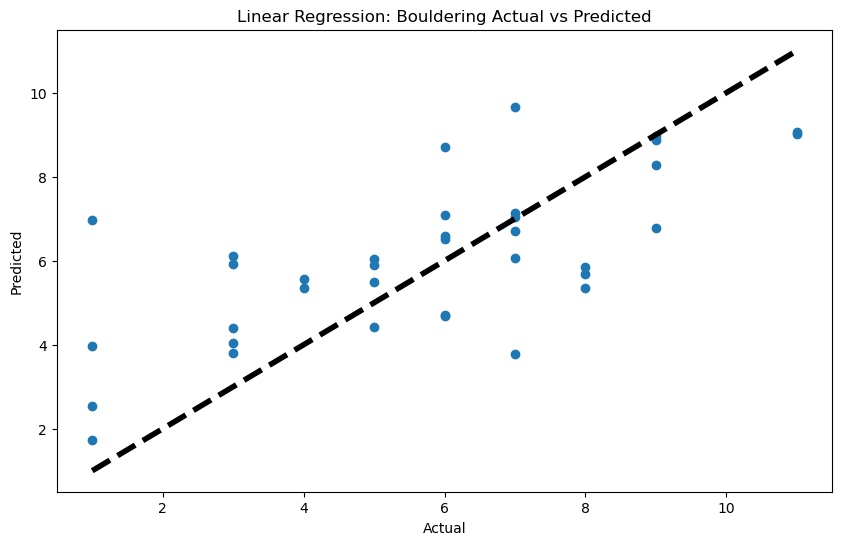

In [73]:
# Step 1: Data Preparation for Linear Regression Bouldering Grade Forecasting
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp', 'days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)


# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrame
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)

# Step 3: Model Selection
# Choose the machine learning algorithm
model = LinearRegression()

# Step 4: Model Training
# Train the model on the training dataset
model.fit(X_train_scaled, y_train)

# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred = model.predict(X_test_scaled)

# Evaluate the model using evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Step 6: Model Fine-tuning (if necessary)

# Step 7: Model Deployment
# Once you are satisfied with the model's performance, you can deploy it to make predictions on new data
# Example prediction
new_data_scaled = scaler.transform(new_data)
predicted_grade_numeric = model.predict(new_data_scaled)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_numeric[0]))
print(f"Predicted Max Boulder Grade: {predicted_grade}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred)  # Use y_pred here
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Linear Regression: Bouldering Actual vs Predicted')

plt.show()

**Linear Regression Model Results**

Mean Squared Error (MSE): This is an average of the square of the errors, or the differences between the true values and the predictions. The MSE for this linear regression model is 7.95, which means the square of the differences between the observed and predicted values averages to 7.95. A lower MSE indicates a better fit to the data. 

Mean Absolute Error (MAE): This is an average of the absolute differences between the true and predicted values. In this case, the MAE is 1.83, which is easier to interpret because it's in the same units as the original data. This means that on average, the predictions are about 1.83 units away from the actual values.

R-squared: R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. Normally, it ranges from 0 to 1, with 1 indicating a perfect fit. However, if the model is worse than a simple mean model, R-squared can be negative, which is the case here (-0.197). This indicates that the linear regression model does not explain much of the variability in the data, and even does worse than a model that simply predicts the mean of the target variable for all observations.

In [74]:
mlflow.sklearn.autolog()

2023/10/22 22:13:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'fdcc83c2d81e4a269f88e17a6bd90d90', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/22 22:17:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpm4w234u1/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:17:13 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp8v41mscf/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:17:13 INFO mlflow.sklearn.uti

Grid search best score: 0.48458994101796166
Grid search best params: {'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Feature: strength_to_weight_pullup, Score: 0.20850
Feature: strength_to_weight_maxhang, Score: 0.48523
Feature: strength_to_weight_weightpull, Score: 0.12748
Feature: exp, Score: 0.04627
Feature: days, Score: 0.13252


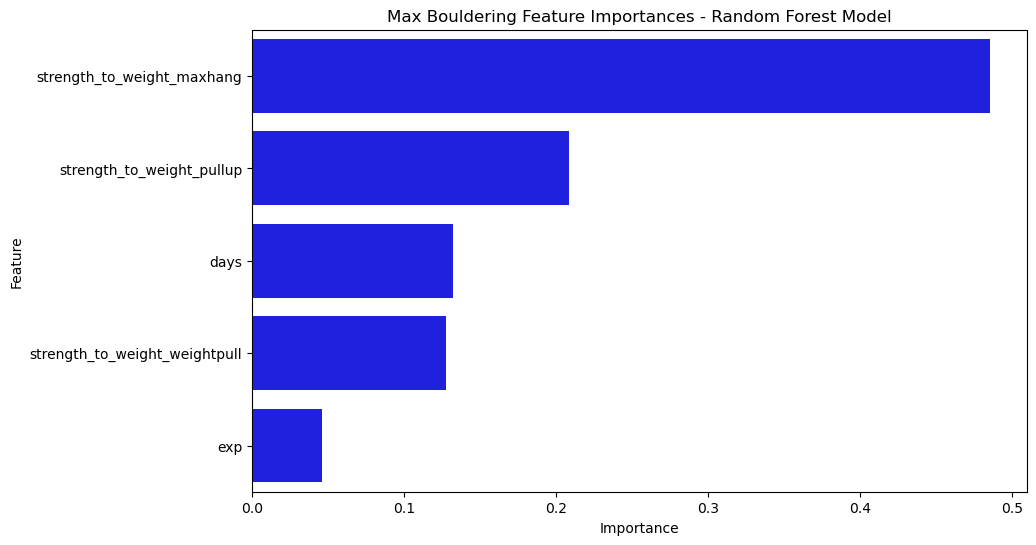

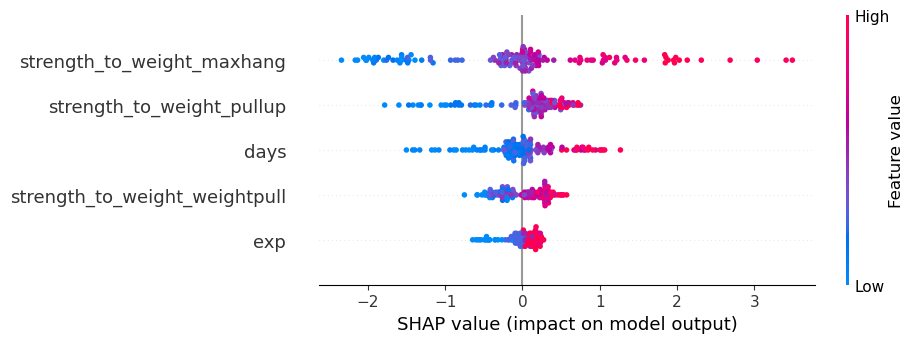

Training Data - Random Forest Mean Squared Error: 0.9611531027346851
Training Data - Random Forest Mean Absolute Error: 0.7902238849344214
Training Data - Random Forest R-squared: 0.8416634778805121
Testing Data - Random Forest Mean Squared Error: 4.273198119645423
Testing Data - Random Forest Mean Absolute Error: 1.6298182699135306
Testing Data - Random Forest R-squared: 0.40546808770150633
Random Forest Predicted Max Boulder Grade: V11


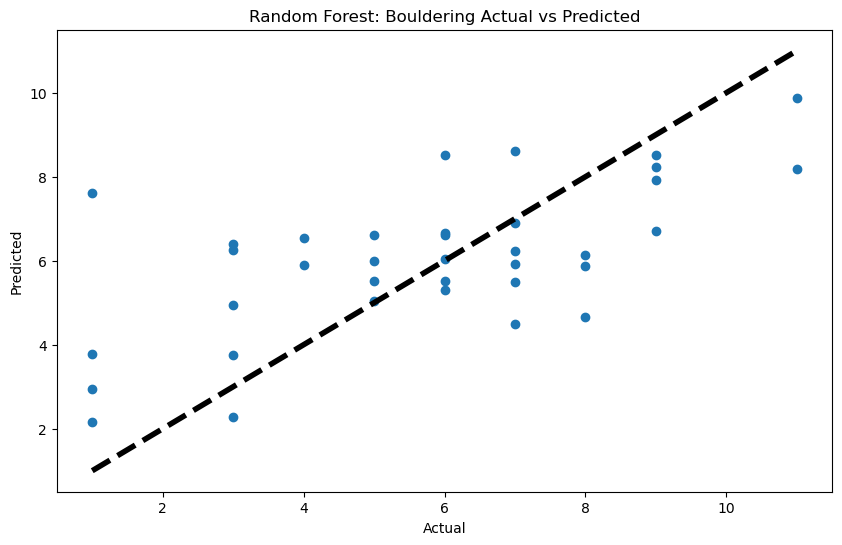

In [75]:
# Step 1: Data Preparation for Bouldering Grade Forecasting - Random Forest Regression
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp', 'days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Step 3: Model Selection
# Choose the machine learning algorithm
model_rf = RandomForestRegressor(random_state=42)  # Don't specify n_estimators here

# Define the parameter values that should be searched
param_grid = {'n_estimators': [100, 200, 300, 500], 
              'max_depth': [None, 6, 8, 10], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4]}

# Instantiate the grid
grid_search = GridSearchCV(model_rf, param_grid, cv=5)

# Step 4: Model Training
# Train the model on the training dataset
grid_search.fit(X_train_scaled, y_train)

# Examine the best model
print(f"Grid search best score: {grid_search.best_score_}")
print(f"Grid search best params: {grid_search.best_params_}")


# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred_rf = grid_search.predict(X_test_scaled)
# Make predictions on the training dataset
y_train_pred_rf = grid_search.predict(X_train_scaled)

# Evaluate the model using evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the feature importance
importance = grid_search.best_estimator_.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))
    
# Create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Bouldering Feature Importances - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Now plot feature importance using SHAP values
# Create a Tree Explainer object
explainer = shap.TreeExplainer(grid_search.best_estimator_,feature_names=X.columns)
shap_values = explainer(X_train_scaled)


# Plot feature importance
shap.plots.beeswarm(shap_values)


# Evaluate the model using evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate the model using evaluation metrics
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
r2_rf_train = r2_score(y_train, y_train_pred_rf)

print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
print(f"Testing Data - Random Forest R-squared: {r2_rf}")


# Predict with new data
predicted_grade_rf = grid_search.predict(new_data_scaled)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_rf[0]))
print(f"Random Forest Predicted Max Boulder Grade: {predicted_grade}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Bouldering Actual vs Predicted')
plt.show()


# Save the best model
with open('best_model_rf.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [76]:
import os
print(os.getcwd())

/Users/thomasgeorgiou/Documents/Coding/Climbing ML Project


**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.55865) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_pullup with a score of 0.18467. It's followed by strength_to_weight_weightpull with a score of 0.13468 and continuous with a score of 0.12200.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_pullup
3. strength_to_weight_weightpull
4. continuous

We can use this information in conjunction with our regression analysis to help determine which feature is in fact the most important and in this case maxhangs comes out on top as both statistically significant and also highly ranked.

**SHAP Results**

As expected max hang ratio comes out on top having the potential to offer a +-3 V grade swing in the prediction, followed by pull up ratio and then continuous hangs. This is quite a large swing (+/-3) but at this point in time I'm not sure how to improve on this.

**Random Forest Model Results**

Mean Squared Error (MSE): In this case, the MSE for the Random Forest model is approximately 4.84. MSE is always non-negative, and a value of 0 would indicate a perfect fit to the data. The smaller the MSE, the better the model's performance.

Mean Absolute Error (MAE): The MAE of the Random Forest model is approximately 1.82.

R-squared (R^2): The R-squared of the  Random Forest model is approximately 0.27 which while still quite low, is better than the linear regression results (-0.197).

Predicted Max Boulder Grade: This is the prediction output of the model for a specific input. In this case, the Random Forest model predicted a Max Boulder Grade of 'V7'.

In summary, based on these metrics, the Random Forest model is performing decently, with some room for improvement. The R-squared value could ideally be higher, as 0.27 indicates that only 27% of the variance in the target variable is being explained by the model. For MSE and MAE, you want these values to be as low as possible.

2023/10/22 22:17:14 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '91322be0c05b4969bd6d34819f4d8025', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/22 22:21:38 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp9stb2_47/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:21:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmptotzwpps/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:21:39 INFO mlflow.sklearn.utils: Logging the 5 best runs, 427 runs will be omitted.


Best parameters:  {'learning_rate': 0.01, 'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 300}
Best score:  0.45674098910657346
Feature: strength_to_weight_pullup, Score: 0.12730
Feature: strength_to_weight_maxhang, Score: 0.58216
Feature: strength_to_weight_weightpull, Score: 0.08322
Feature: exp, Score: 0.07245
Feature: days, Score: 0.13487


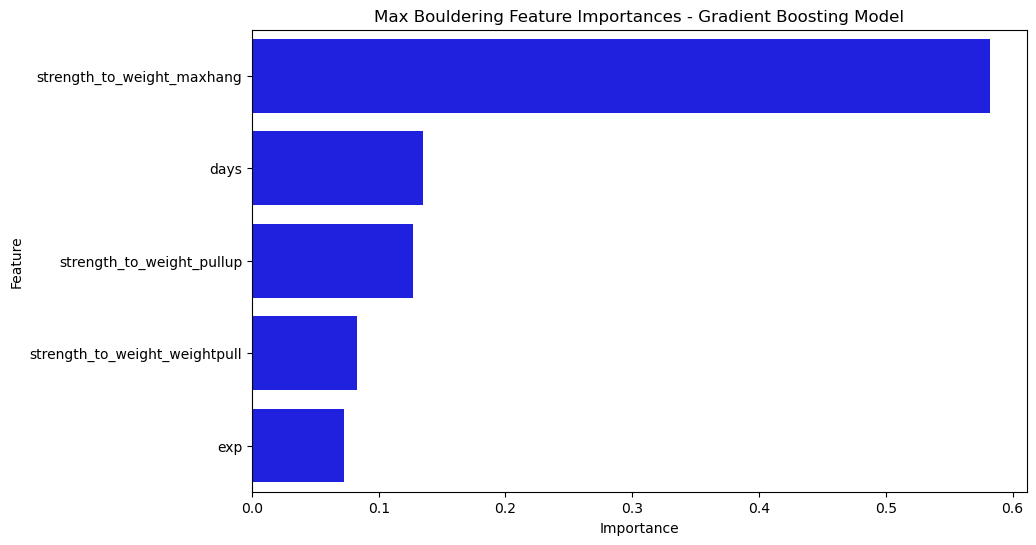

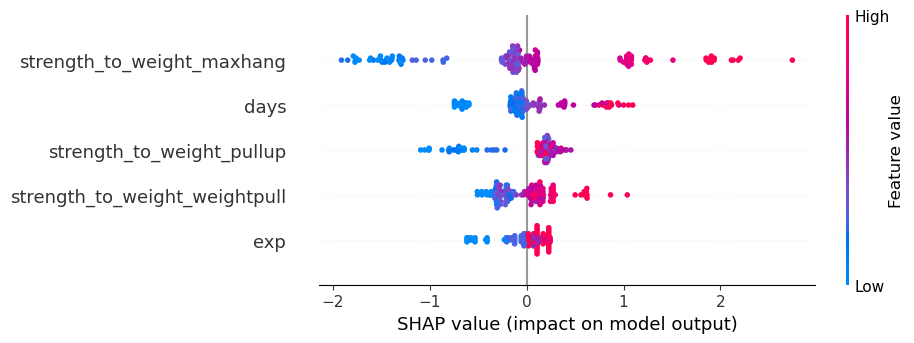

Training Data - Gradient Boosting Mean Squared Error: 1.6931754266887413
Training Data - Gradient Boosting Mean Absolute Error: 1.0696910196573735
Training Data - Gradient Boosting R-squared: 0.7210730448278242
Testing Data - Gradient Boosting Mean Squared Error: 4.058631253563643
Testing Data - Gradient Boosting Mean Absolute Error: 1.6585998047902089
Testing Data - Gradient Boosting R-squared: 0.43532086906940626
Gradient Boosting Predicted Max Boulder Grade: V12


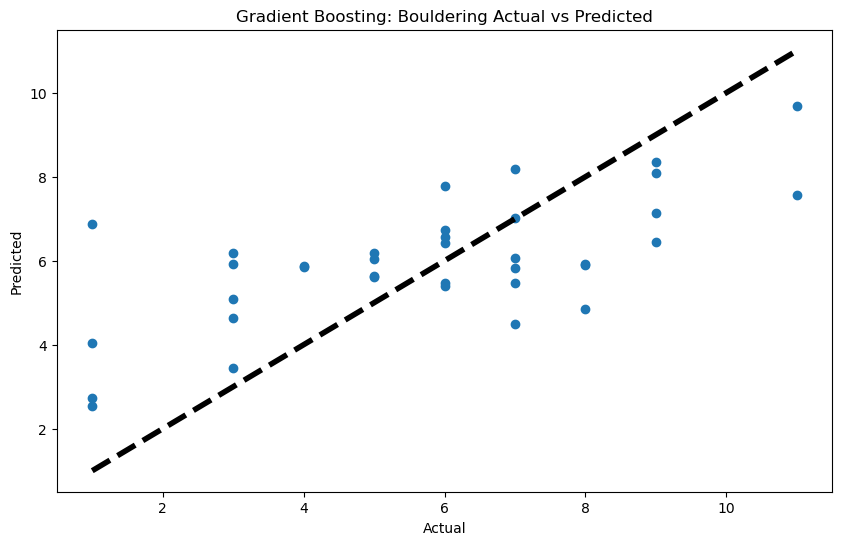

In [77]:
# Step 1: Data Preparation for Bouldering Grade Forecasting - Gradient Boosting Model
X = data_filtered_bouldering[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp', 'days']]
y_boulder = data_filtered_bouldering['max_boulder_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_boulder, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Step 3: Model Selection with Grid Search
model_gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid
param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5)

# Step 4: Model Training
grid_search_gb.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_gb.best_params_)
print("Best score: ", grid_search_gb.best_score_)

# Make the best model the new Gradient Boosting model
model_gb = grid_search_gb.best_estimator_

# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred_gb = model_gb.predict(X_test_scaled)
# Make predictions on the training dataset
y_train_pred_gb = model_gb.predict(X_train_scaled)


# Evaluate the model using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print the feature importance
importance = model_gb.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))

# Get feature importances
importances = model_gb.feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Bouldering Feature Importances - Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Now plot feature importance using SHAP values
# Create a Tree Explainer object
explainer = shap.Explainer(model_gb,feature_names=X.columns)
shap_values = explainer(X_train_scaled)

# Plot feature importance
shap.plots.beeswarm(shap_values)


# Evaluate the model using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Evaluate the model using evaluation metrics
mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
r2_gb_train = r2_score(y_train, y_train_pred_gb)

print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")

# Predict with new data
predicted_grade_gb = model_gb.predict(new_data_scaled)
predicted_grade = convert_numeric_to_v_grade(float(predicted_grade_gb[0]))
print(f"Gradient Boosting Predicted Max Boulder Grade: {predicted_grade}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Bouldering Actual vs Predicted')
plt.show()

In [78]:
autolog_run = mlflow.last_active_run()

**Feature Importance Results**

Strength_to_weight_maxhang is the most important feature (with a score of 0.65) in predicting the output variable in the model. This means that changes in strength_to_weight_maxhang have the biggest effect on the model's predictions.

The second most important feature is strength_to_weight_weightpull followed by strength_to_weight_pull.

So, in terms of predictive power for the model, the features rank as follows:

1. strength_to_weight_maxhang
2. strength_to_weight_weightpull
3. strength_to_weight_pull
4. continuous

These results are slightly different from the RF model in that number 2 and 3 are swapped. This still leaves the max hangs to bodyweight ratio at the top.

**SHAP Results**

Again as expected the maxhangs ratio comes out on top having the potential to offer a +-2 V grade swing in the prediction, followed by weighted pullups ratio, pullup ratio and then continuous hangs. This is slightly different to the Random Forest where it was pullup ratio, continuous, and then weighted pullup ratio, however max hangs is still on top.

**Gradient Boosting Model Results**

Mean Squared Error (MSE): The MSE for the Gradient Boosting model is approximately 4.66. This represents the average of the squares of the differences between the predicted and actual values. A smaller MSE is better as it indicates fewer errors in predictions.

Mean Absolute Error (MAE): The MAE for the Gradient Boosting model is approximately 1.75. This measures the average magnitude of the errors in predictions, irrespective of their direction. Like MSE, a smaller MAE value is better.

R-squared (R^2): The R-squared for the Gradient Boosting model is approximately 0.298. This value indicates that the model explains about 29.8% of the variance in the target variable. 

In summary, the Gradient Boosting model performs a bit better than the Random Forest model, based on these metrics. The R-squared value is slightly higher, indicating that it can explain a bit more variance in the target variable. The MAE and MSE are also slightly lower, indicating fewer prediction errors.

2023/10/23 12:00:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '1e6d962f34ab4fe3bc56c6fb70a8aa65', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/23 12:00:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpy0nzruil/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.3.1', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


Mean Squared Error: 5.332291457879395
Mean Absolute Error: 1.8756537378424254
R-squared: 0.5915691649283867
Predicted Max Sport Grade: Unknown grade


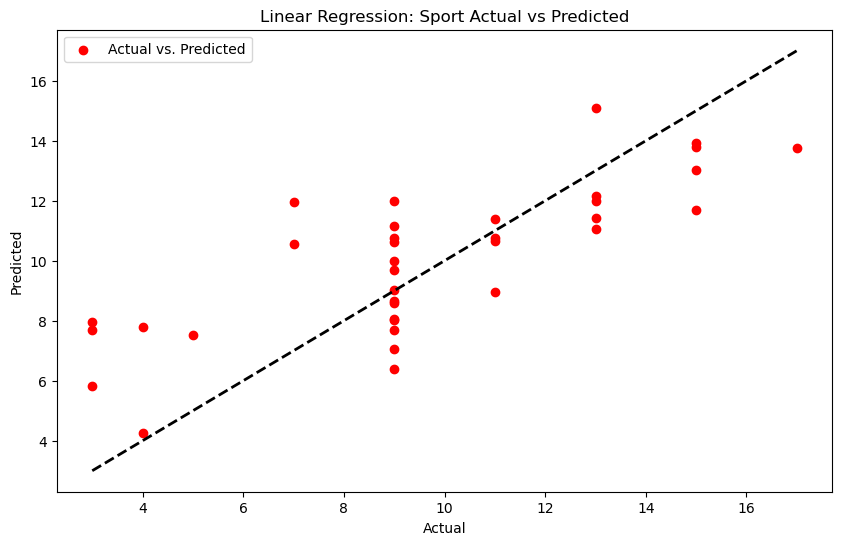

In [84]:
# Step 1: Data Preparation for Linear Regression Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Step 3: Model Selection
# Choose the machine learning algorithm
model = LinearRegression()

# Step 4: Model Training
# Train the model on the training dataset
model.fit(X_train_scaled, y_train)

# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred = model.predict(X_test_scaled)

# Evaluate the model using evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R-squared: {r2}")

# Step 6: Model Fine-tuning (if necessary)

# Step 7: Model Deployment

# Example prediction
predicted_grade = model.predict(new_data_scaled)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade[0]))
print(f"Predicted Max Sport Grade: {predicted_grade}")

# Plotting for Linear Regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='r', label='Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.legend()
plt.title('Linear Regression: Sport Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

# Save the best model
with open('best_model_rf_sport.pkl', 'wb') as f:
    pickle.dump(grid_search.best_estimator_, f)

# Save the scaler
with open('scaler_sport.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Linear regression results for sport climbing are significantly better than what they were for bouldering with an R^2 of 0.24. This is our most basic model, so let's see if we can improve on this score with the RF and GB models.

In [80]:
# To check the total number of rows and columns in your DataFrame
total_rows, total_columns = data_filtered_sport.shape

# To check just the total number of rows
total_rows = len(data_filtered_sport)

# To print these values
print(f"Total number of rows: {total_rows}")
print(f"Total number of columns: {total_columns}")

Total number of rows: 177
Total number of columns: 26


2023/10/22 22:21:40 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b89c60a6358e4a67bdae94e3c49f8beb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2023/10/22 22:24:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmphwzdzdxd/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:24:56 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpl9i5t_9e/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:24:56 INFO mlflow.sklearn.uti

0.4543359500340386
{'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


2023/10/22 22:24:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpxpxeff9m/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.


Feature: strength_to_weight_pullup, Score: 0.20845
Feature: strength_to_weight_maxhang, Score: 0.22892
Feature: strength_to_weight_weightpull, Score: 0.21183
Feature: exp, Score: 0.11083
Feature: days, Score: 0.23998


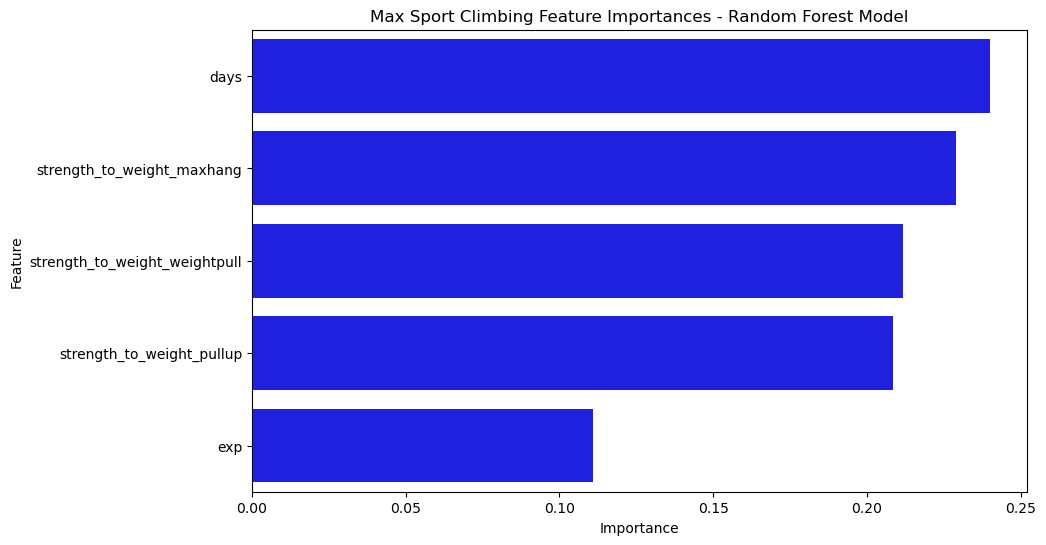

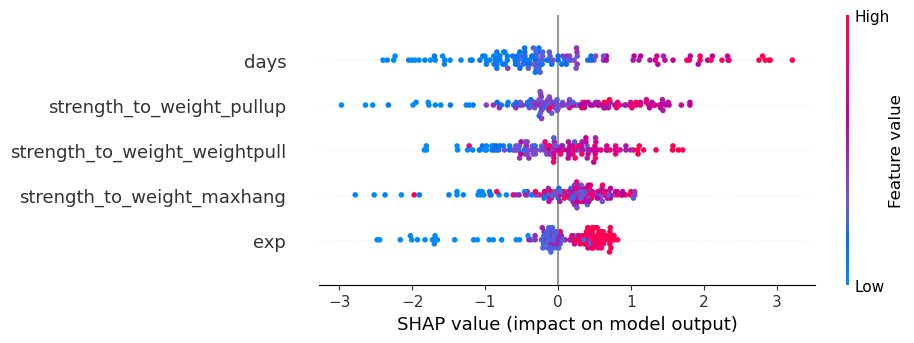

Training Data - Random Forest Mean Squared Error: 0.9024334468085106
Training Data - Random Forest Mean Absolute Error: 0.747418439716312
Training Data - Random Forest R-squared: 0.9291105095618916
Testing Data - Random Forest Mean Squared Error: 5.7367956666666675
Testing Data - Random Forest Mean Absolute Error: 1.7925
Testing Data - Random Forest R-squared: 0.5605858638297871
Random Forest Predicted Predicted Max Sport Grade: 7c


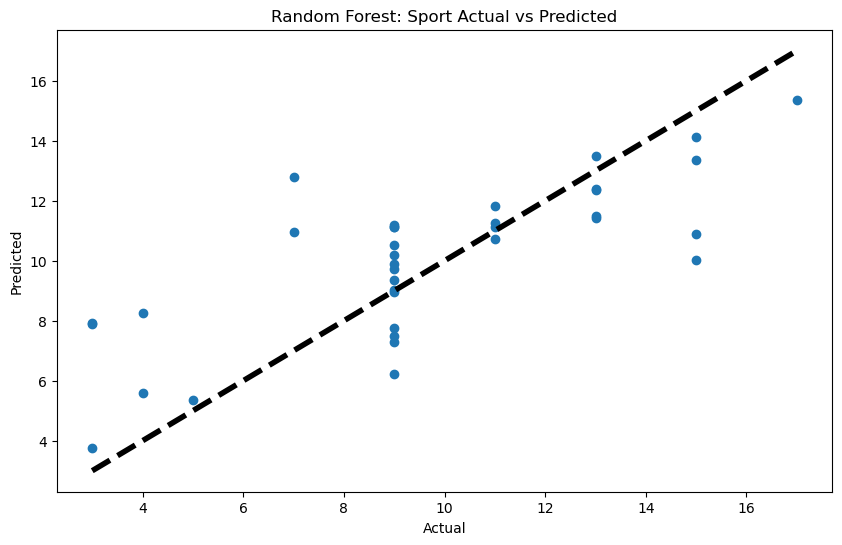

In [81]:
from sklearn.ensemble import RandomForestRegressor

# Step 1: Data Preparation for RFR Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Step 3: Model Selection
# Choose the machine learning algorithm
model_rf = RandomForestRegressor(random_state=42)  # Don't specify n_estimators here

# Define the parameter values that should be searched
param_grid = {'n_estimators': [100, 200, 300, 500], 
              'max_depth': [None, 6, 8, 10], 
              'min_samples_split': [2, 5, 10], 
              'min_samples_leaf': [1, 2, 4]}

# Instantiate the grid
grid_search = GridSearchCV(model_rf, param_grid, cv=5)

# Step 4: Model Training
# Train the model on the training dataset
grid_search.fit(X_train_scaled, y_train)

# Examine the best model
print(grid_search.best_score_)
print(grid_search.best_params_)

# Make the best model the new random forest model
model_rf = grid_search.best_estimator_


# Step 4: Model Training
# Train the model on the training dataset
model_rf.fit(X_train_scaled, y_train)


# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred_rf = model_rf.predict(X_test_scaled)
# Make predictions on the training dataset
y_train_pred_rf = model_rf.predict(X_train_scaled)

# Evaluate the model using evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Print the feature importance
importance = model_rf.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))

# Create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Max Sport Climbing Feature Importances - Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Now plot feature importance using SHAP values
# Create a Tree Explainer object
explainer = shap.Explainer(model_rf,feature_names=X.columns)
shap_values = explainer(X_train_scaled)

# Plot feature importance
shap.plots.beeswarm(shap_values)


# Evaluate the model using evaluation metrics
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Evaluate the model using evaluation metrics
mse_rf_train = mean_squared_error(y_train, y_train_pred_rf)
mae_rf_train = mean_absolute_error(y_train, y_train_pred_rf)
r2_rf_train = r2_score(y_train, y_train_pred_rf)

print(f"Training Data - Random Forest Mean Squared Error: {mse_rf_train}")
print(f"Training Data - Random Forest Mean Absolute Error: {mae_rf_train}")
print(f"Training Data - Random Forest R-squared: {r2_rf_train}")

print(f"Testing Data - Random Forest Mean Squared Error: {mse_rf}")
print(f"Testing Data - Random Forest Mean Absolute Error: {mae_rf}")
print(f"Testing Data - Random Forest R-squared: {r2_rf}")

# Predict with new data
predicted_grade_rf = model_rf.predict(new_data_scaled)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_rf[0]))
print(f"Random Forest Predicted Predicted Max Sport Grade: {predicted_grade}")

y_pred_rf = model_rf.predict(X_test_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest: Sport Actual vs Predicted')
plt.show()

**Feature Importance Results**

What's interesting with the below results is how different they are to the bouldering results. Max hang ratio seems to have the least influential role to play, while weighted pullups ratio and continuous play a bigger role. We could make an assumption and say that being able to hang on to small edges for longer is more beneficial in sport climbing, as is being able to pull more than your bodyweight for longer periods of time (thus weighted pullups to weight ratio also being important).

strength_to_weight_weightpull: This feature has an importance score of 0.34933. It means that, on average, changing the value of this feature has a significant effect on the predicted max sport climbing grade. It is the most influential feature among all four features.

continuous: This feature has an importance score of 0.25615. It means that, on average, changing the value of this feature has a quite substantial effect on the predicted max sport climbing grade. It is the second most influential feature in the model.

strength_to_weight_pullup: This feature has an importance score of 0.19961. It means that, on average, changing the value of this feature has a moderate effect on the predicted max sport climbing grade. This is the second least influential feature in the model.

strength_to_weight_maxhang: This feature has an importance score of 0.19492. It means that, on average, changing the value of this feature also has a moderate effect on the predicted max sport climbing grade. It is the least influential feature among the four.


**SHAP Results**

Again another interesting thing to see here is that the continuous and weighted pullup ratio have swapped, inidicating that a a change in the ability to hang for a longer period of time on a 20mm edge is likely to swing your max sport grade by +/- 2. I think it's also worth noting that it looks like having a lower weighted pullup to bodyweight ratio is more detrimental than not being able to hang as long continuously, as the swing for continuos is between +2.5 and -3.5

**Random Forest Model Results**

Mean Squared Error (MSE): An MSE of 8.87 means that, on average, the squared difference between the predicted and actual values is 8.87. The lower this value is, the better the model's performance.

Mean Absolute Error (MAE): The MAE for the model is 2.5, which means that, on average, the predictions are off by around 2.5 units.

R-squared: An R-squared of 100 percent indicates that all changes in the dependent variable are completely explained by changes in the independent variable(s). This model's R-squared is approximately 0.36, indicating that around 36% of the variability in the 'max_sport_numeric' is accounted for by the features in the model.

2023/10/22 22:24:59 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b154d79a03c6476eb61e09363510c92b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2023/10/22 22:29:35 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmpfe52_1ud/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:29:36 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/sx/gln2n4bn79s56t8nlszt_1g00000gn/T/tmp2xgkl7ed/model/model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.2.2', 'cloudpickle==2.2.1']. Set logging level to DEBUG to see the full traceback.
2023/10/22 22:29:36 INFO mlflow.sklearn.utils: Logging the 5 best runs, 427 runs will be omitted.


Best parameters:  {'learning_rate': 0.01, 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}
Best score:  0.4505584303391436
Feature: strength_to_weight_pullup, Score: 0.20845
Feature: strength_to_weight_maxhang, Score: 0.22892
Feature: strength_to_weight_weightpull, Score: 0.21183
Feature: exp, Score: 0.11083
Feature: days, Score: 0.23998


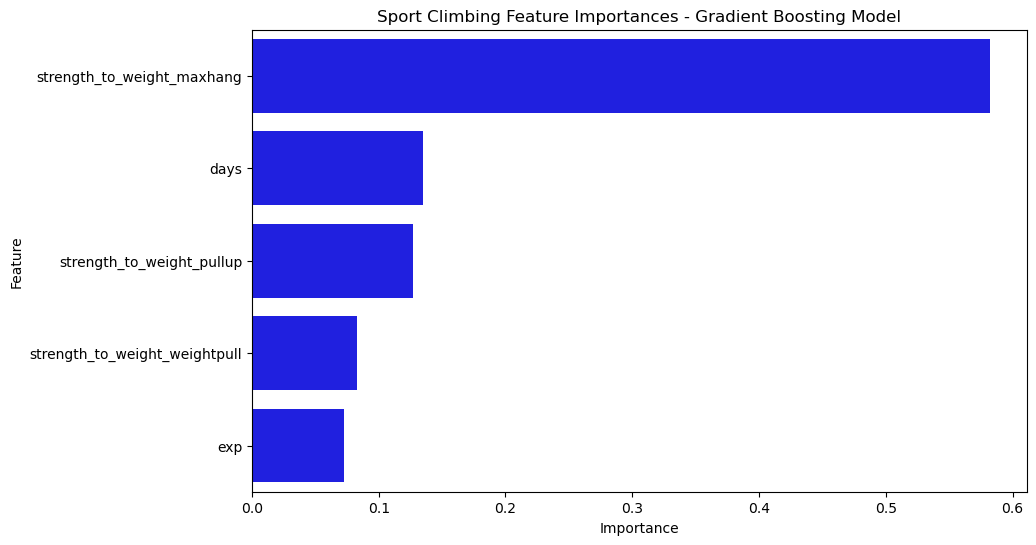

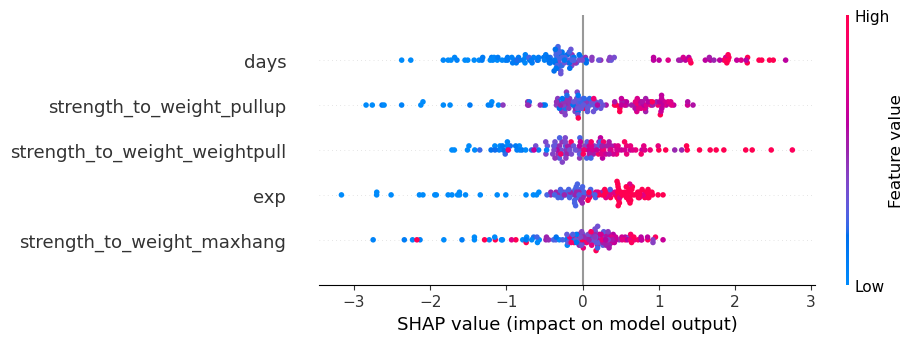

Training Data - Gradient Boosting Mean Squared Error: 1.6603405304879773
Training Data - Gradient Boosting Mean Absolute Error: 0.9636190202041005
Training Data - Gradient Boosting R-squared: 0.8695741003657562
Testing Data - Gradient Boosting Mean Squared Error: 6.060112122036115
Testing Data - Gradient Boosting Mean Absolute Error: 1.8386861393953007
Testing Data - Gradient Boosting R-squared: 0.5358211991631912
Gradient Boosted Predicted Predicted Max Sport Grade: 7a+


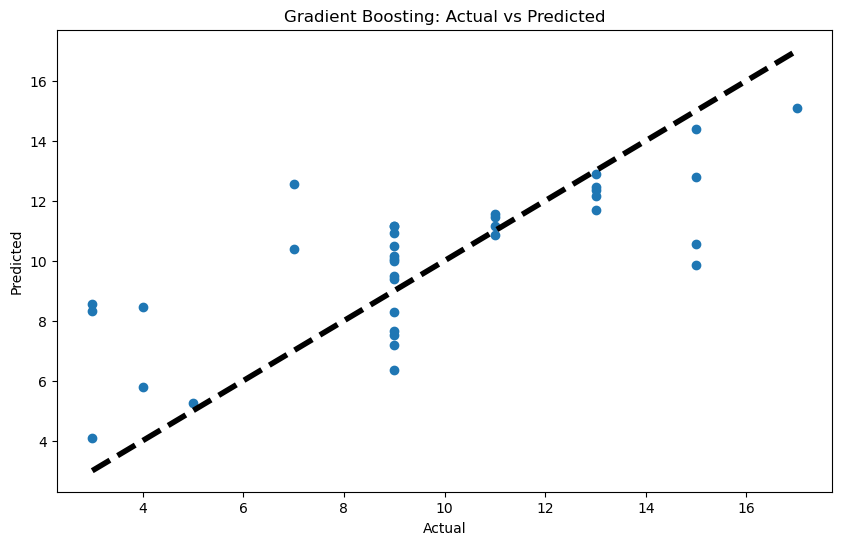

In [82]:
from sklearn.ensemble import GradientBoostingRegressor

# Step 1: Data Preparation for Sport Grade Forecasting
X = data_filtered_sport[['strength_to_weight_pullup', 'strength_to_weight_maxhang', 'strength_to_weight_weightpull','exp','days']]
y_sport = data_filtered_sport['max_sport_numeric']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sport, test_size=0.2, random_state=42)

# Step 2: Feature Engineering
# Perform any necessary data preprocessing steps such as handling missing values and scaling numeric variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Step 3: Model Selection with Grid Search
model_gb = GradientBoostingRegressor(random_state=42)

# Define the parameters grid
param_grid_gb = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 3]
}

# Instantiate the grid search
grid_search_gb = GridSearchCV(model_gb, param_grid_gb, cv=5)

# Step 4: Model Training
grid_search_gb.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print("Best parameters: ", grid_search_gb.best_params_)
print("Best score: ", grid_search_gb.best_score_)

# Make the best model the new Gradient Boosting model
model_gb = grid_search_gb.best_estimator_

# Step 5: Model Evaluation
# Make predictions on the testing dataset
y_pred_gb = model_gb.predict(X_test_scaled)
# Make predictions on the training dataset
y_train_pred_gb = model_gb.predict(X_train_scaled)

# Evaluate the model using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Print the feature importance
importance = model_rf.feature_importances_
for i, j in enumerate(importance):
    print('Feature: %s, Score: %.5f' % (X.columns[i],j))

# Get feature importances
importance = model_gb.feature_importances_

# Create a dataframe for visualization
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', color='b')
plt.title('Sport Climbing Feature Importances - Gradient Boosting Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


# Now plot feature importance using SHAP values
# Create a Tree Explainer object
explainer = shap.Explainer(model_gb,feature_names=X.columns)
shap_values = explainer(X_train_scaled)

# Plot feature importance
shap.plots.beeswarm(shap_values)

# Evaluate the model using evaluation metrics
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

# Evaluate the model using evaluation metrics
mse_gb_train = mean_squared_error(y_train, y_train_pred_gb)
mae_gb_train = mean_absolute_error(y_train, y_train_pred_gb)
r2_gb_train = r2_score(y_train, y_train_pred_gb)

print(f"Training Data - Gradient Boosting Mean Squared Error: {mse_gb_train}")
print(f"Training Data - Gradient Boosting Mean Absolute Error: {mae_gb_train}")
print(f"Training Data - Gradient Boosting R-squared: {r2_gb_train}")

print(f"Testing Data - Gradient Boosting Mean Squared Error: {mse_gb}")
print(f"Testing Data - Gradient Boosting Mean Absolute Error: {mae_gb}")
print(f"Testing Data - Gradient Boosting R-squared: {r2_gb}")


# Predict with new data
predicted_grade_gb = model_gb.predict(new_data_scaled)
predicted_grade = convert_numeric_to_f_grade(float(predicted_grade_gb[0]))
print(f"Gradient Boosted Predicted Predicted Max Sport Grade: {predicted_grade}")


plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_gb)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Gradient Boosting: Actual vs Predicted')
plt.show()

**Feature Importance**

strength_to_weight_weightpull: With a score of 0.34933, this feature is the most important one and contributes approximately 34.93% to the overall prediction. This suggests that the strength to weight ratio during weighted pulls is the most critical factor in determining the maximum bouldering grade.

continuous: This feature's score is 0.25615, contributing about 25.61% to the overall prediction of the model.

strength_to_weight_pullup: A score of 0.19961 indicates that this feature contributes about 19.96% to the overall prediction of our model. It means the strength to weight ratio during pull-ups is a substantial factor in predicting the maximum bouldering grade.

strength_to_weight_maxhang: A score of 0.19492 shows this feature contributes about 19.49% to the overall prediction. The strength to weight ratio during max hangs is another substantial factor in predicting the maximum bouldering grade.


**SHAP Results**

Weighted pullup ratio has the largest swing by far with a +2 / -4 range. We could interpret this as: your strength to weight weighted pullup ratio could help you gain 2 grades (assuming you can add weight to your pullups), but it could also affect you negatively by around 4 grades - this might not be a 100% correct assumption, but it seems like a reasonable interpretation; if you can do pullups with your bodyweight + added weight, then climbing up a wall with just your bodyweight will seem easier. Similarly if you can't do pullups with bodyweight + added weight, then it's more likely you will tire faster.


**Gradient Boosting Model Results**

Mean Squared Error (MSE): The score is 9.61. A lower MSE means a better model. Since the MSE is relatively high, there might be significant differences between the actual and the predicted values.

Mean Absolute Error (MAE): This is the average absolute difference between the actual and the predicted values, which is 2.63. A lower MAE means a better model. A MAE of 2.63 means that on average, the model's predictions are about 2.63 units away from the actual value.

R-Squared: This is a statistical measure that represents the proportion of the variance for a dependent variable that's explained by an independent variable or variables in a regression model. The R-squared is approximately 0.304. It means around 30.4% of the variability in the max sport grade can be explained by the chosen features. This is not very high, but it's the best out of the 3 models I have chosen for this analysis.

![Rise of the sleepwalker](https://cdn.shopify.com/s/files/1/1554/2851/articles/sleepwalker-vid_e353c25c-7fdb-45ae-8bff-5f17eb8dad7c_1600x.jpg?v=1624463336)

**Final Thoughts**

Based on the above it's clear to see there are differences between what makes a strong boulderer and a strong sport climber, although there is definitely overlap between the two. The below overalls are based on the model with the lowest R^2.

Overall for bouldering, the order of priority seems to be:

1. strength_to_weight_maxhang
2. strength_to_weight_weightpull
3. strength_to_weight_pull
4. continuous

This seems like a reasonable outcome given the raw strength and power needed for bouldering in the upper grades, with endurance (continuous) being a smaller priority.


Overall for sport climbing, the order of priority seems to be:

1. strength_to_weight_weightpull
2. continuous
3. strength_to_weight_pull
4. strength_to_weight_maxhang

However I think it's worth noting that the Gradient Boosting model had quite a different result on feature importance for sport climbing, showing as:

1. strength_to_weight_weightpull
2. strength_to_weight_maxhang
3. continuous 
4. strength_to_weight_pull

The top performing variable is still the same, but maxhangs ratio takes second place, with continuous in 3rd. If we look at these together it looks like strength to weight ratio weighted pullups still comes out on top for sport climbing, with abit of uncertainty whether endurance or strength comes in second. However there are other factors to consider like maybe the more you train max hangs, your ability to hang on a 20mm edge for longer also increases, or vice versa.

**Further thoughts**

I would like to also add a widget to this workbook so people can play around with the model inputs and see what predicted grade they get, which would be both fun but also another form of validation.

I also think it might be worth re-running the sport climbing models using other variables which ranke more important in the Spearman analysis and see if the models come out with a higher R^2.

Hope that was interesting, any thoughts/feedback/improvements you would make let me know!

In [83]:
import numpy
import pandas
import matplotlib
import seaborn
import scipy
import sklearn
import statsmodels
import shap
import mlflow
import pickle
import streamlit
import requests

print("NumPy version:", numpy.__version__)
print("Pandas version:", pandas.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", seaborn.__version__)
print("SciPy version:", scipy.__version__)
print("Scikit-Learn version:", sklearn.__version__)
print("Statsmodels version:", statsmodels.__version__)
print("SHAP version:", shap.__version__)
print("MLflow version:", mlflow.__version__)
print("Streamlit version:", streamlit.__version__)
print("Requests version:", requests.__version__)

# Note: pickle is a standard library module, so it doesn't have a __version__ attribute


NumPy version: 1.24.3
Pandas version: 1.5.3
Matplotlib version: 3.7.1
Seaborn version: 0.12.2
SciPy version: 1.10.0
Scikit-Learn version: 1.2.1
Statsmodels version: 0.13.5
SHAP version: 0.42.1
MLflow version: 2.6.0
Streamlit version: 1.27.2
Requests version: 2.28.1
